In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import missingno as msno
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR
import torch.nn.functional as F

#sns.set()

%matplotlib inline

/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# !pip install xgboost

1. initialize data
- drop MAR,MCAR missing value
- fill MNAR missing value
- type convert(date,price,etc)
- drop outliers
2. feature engineering
- multicollinearity
- one hot encode
3. quick random forest: see the important features
4. tune paremeters

# Initialize Data

In [4]:
df2024_1=pd.read_csv('df2024_1.csv')

In [5]:
df2024_1.drop(['id', 'listing_url', 'scrape_id','source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name','host_location', 'host_about','host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications', 'neighbourhood','latitude','neighbourhood_group_cleansed','calendar_last_scraped',
       'longitude','license'],axis=1,inplace=True)

In [6]:
df2024_1.dtypes

last_scraped                                     object
host_since                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                                object
host_has_profile_pic                             object
host_identity_verified                           object
neighbourhood_cleansed                           object
property_type                                    object
room_type                                        object
accommodates                                      int64
bathrooms                                       float64
bathrooms_text                                   object
bedrooms                                        float64
beds                                            float64
amenities                                        object
price                                           

In [7]:
df2024_1.describe()

accommodates     bathrooms      bedrooms          beds  minimum_nights  \
count  39202.000000  24335.000000  33011.000000  24222.000000    39202.000000   
mean       2.848860      1.202979      1.403532      1.681736       29.634432   
std        2.029674      0.556281      0.953565      1.254421       30.172981   
min        1.000000      0.000000      0.000000      0.000000        1.000000   
25%        2.000000      1.000000      1.000000      1.000000       30.000000   
50%        2.000000      1.000000      1.000000      1.000000       30.000000   
75%        4.000000      1.000000      2.000000      2.000000       30.000000   
max       16.000000     15.500000     26.000000     42.000000     1250.000000   

       maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
count    3.920200e+04            39200.000000            39200.000000   
mean     5.640459e+04               29.583495               37.791480   
std      1.084709e+07               32.040758               60.007764   
min      1.000000e+00                1.000000                1.000000   
25%      1.500000e+02               30.000000               30.000000   
50%      3.650000e+02               30.000000               30.000000   
75%      1.125000e+03               30.000000               30.000000   
max      2.147484e+09             1250.000000             1250.000000   

       minimum_maximum_nights  maximum_maximum_nights  ...  \
count            3.920000e+04            3.920000e+04  ...   
mean             7.686786e+05            1.700019e+06  ...   
std              4.057712e+07            6.036737e+07  ...   
min              1.000000e+00            1.000000e+00  ...   
25%              3.650000e+02            3.650000e+02  ...   
50%              1.125000e+03            1.125000e+03  ...   
75%              1.125000e+03            1.125000e+03  ...   
max              2.147484e+09            2.147484e+09  ...   

       review_scores_cleanliness  review_scores_checkin  \
count               27713.000000           27698.000000   
mean                    4.629591               4.814092   
std                     0.553984               0.420550   
min                     0.000000               0.000000   
25%                     4.500000               4.800000   
50%                     4.800000               4.940000   
75%                     5.000000               5.000000   
max                     5.000000               5.000000   

       review_scores_communication  review_scores_location  \
count                 27708.000000            27696.000000   
mean                      4.808529                4.727991   
std                       0.448769                0.418802   
min                       0.000000                0.000000   
25%                       4.800000                4.630000   
50%                       4.960000                4.840000   
75%                       5.000000                5.000000   
max                       5.000000                5.000000   

       review_scores_value  calculated_host_listings_count  \
count         27697.000000                    39202.000000   
mean              4.624456                       46.842661   
std               0.518733                      146.693303   
min               0.000000                        1.000000   
25%               4.510000                        1.000000   
50%               4.760000                        1.000000   
75%               4.930000                        6.000000   
max               5.000000                      827.000000   

       calculated_host_listings_count_entire_homes  \
count                                 39202.000000   
mean                                     24.227565   
std                                     120.567818   
min                                       0.000000   
25%                                       0.000000   
50%                                       1.000000   
75%                             

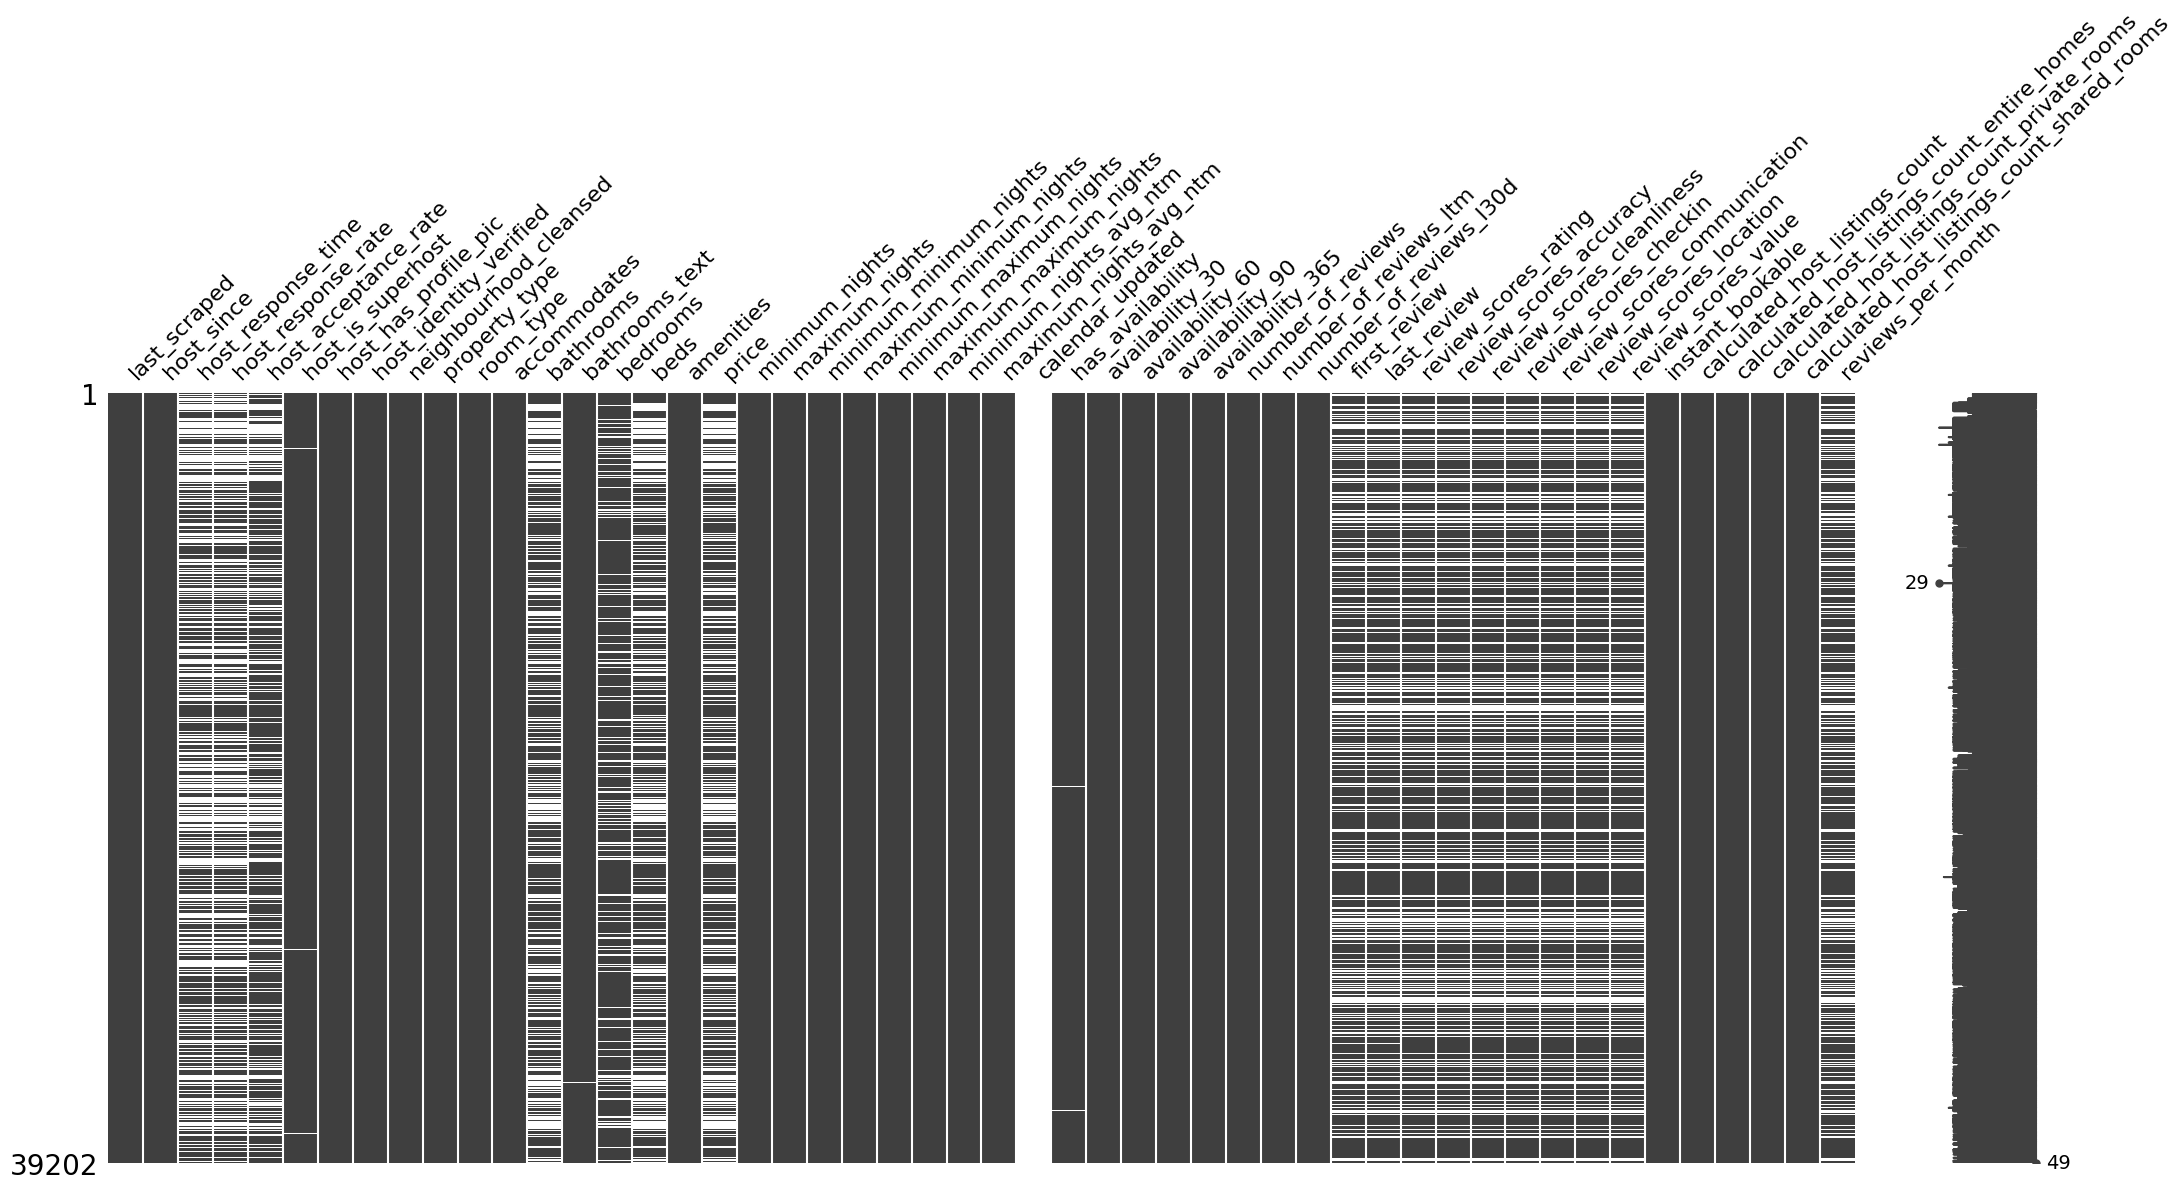

ValueError: could not convert string to float: '--'

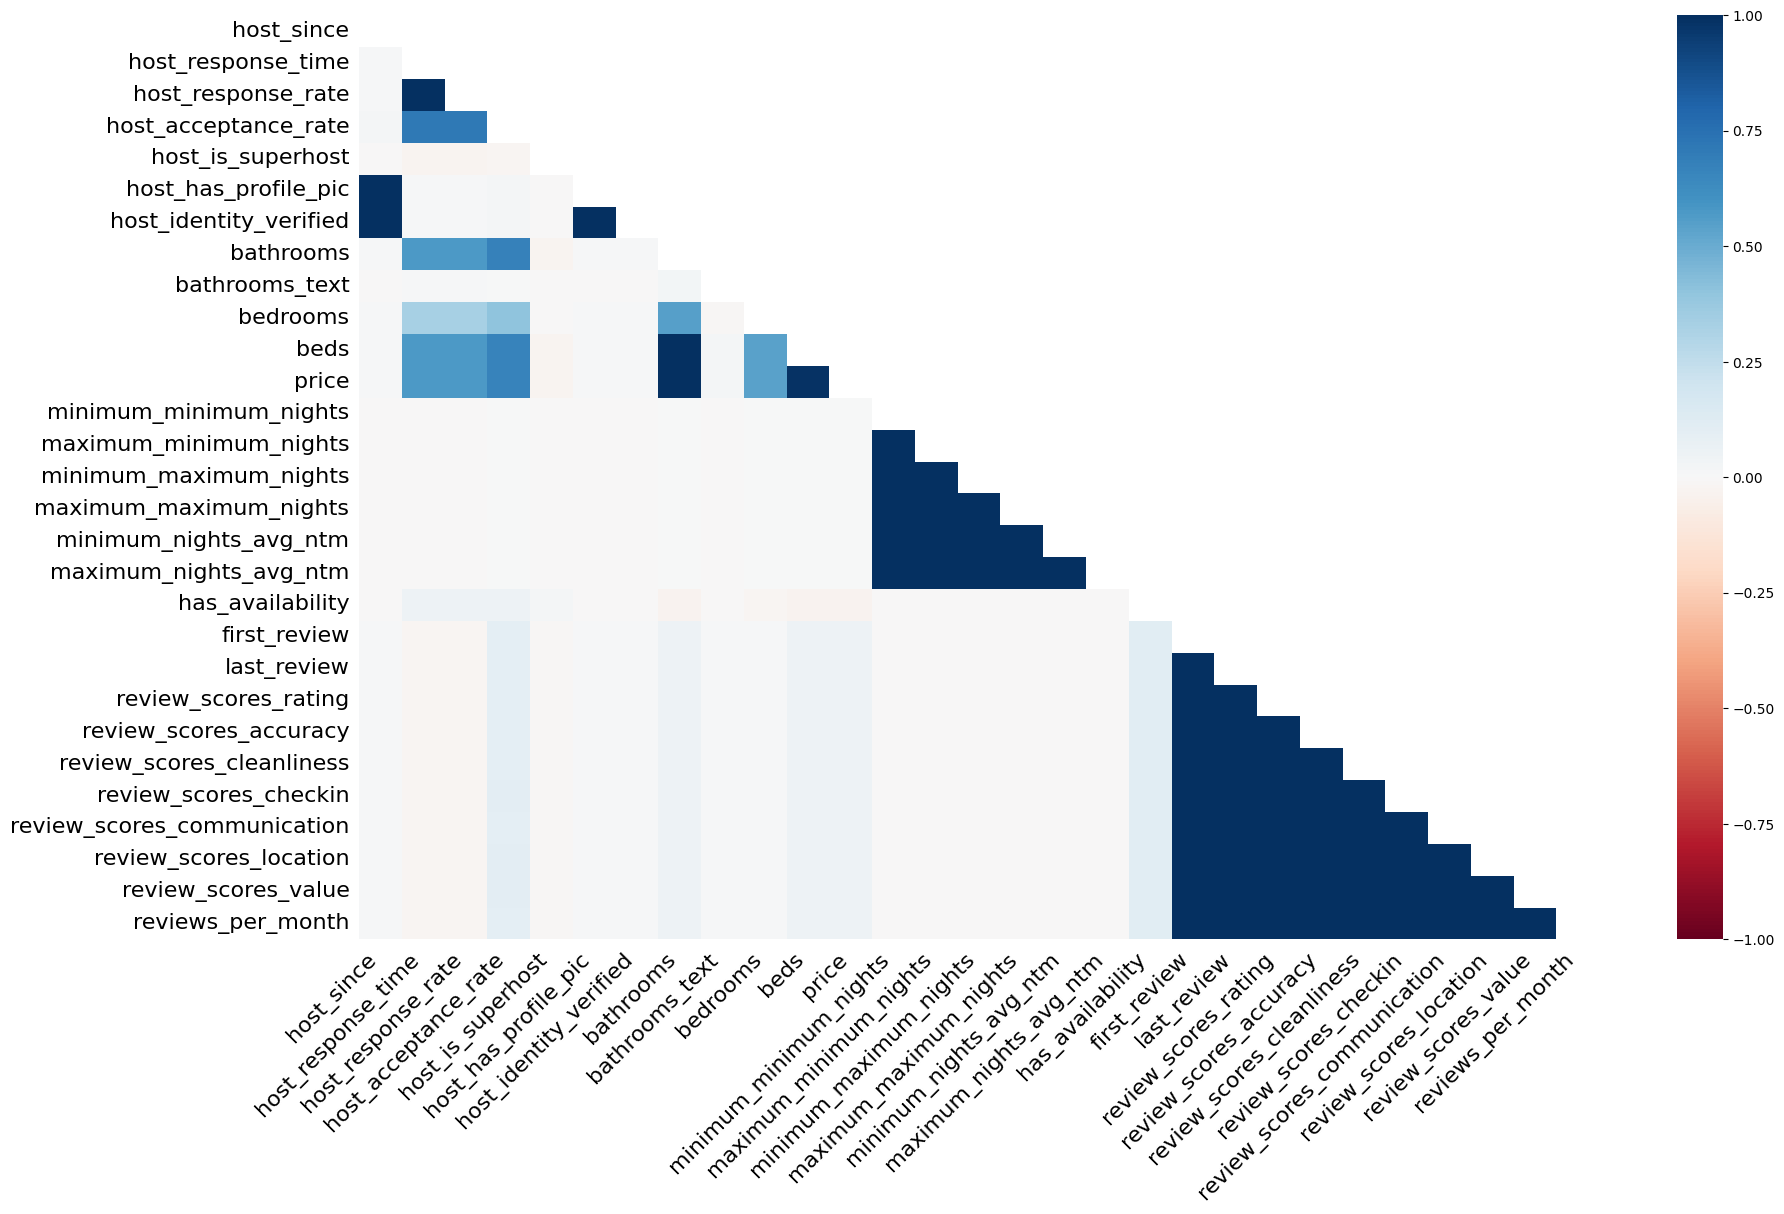

In [8]:
# Visualize the missingness matrix
msno.matrix(df2024_1)
plt.show()

# Heatmap of missingness correlation
msno.heatmap(df2024_1)
plt.show()

In [9]:
# drop missing values
columns_to_check = ['host_since', 'host_is_superhost', 'has_availability', 'calendar_updated', 'bathrooms_text','price']
threshold = 0.7  # 70% threshold for missing values

for col in columns_to_check:
    missing_proportion = df2024_1[col].isna().mean()  # Proportion of missing values
    if missing_proportion > threshold:
        # Drop the column
        df2024_1.drop(col, axis=1, inplace=True)
    elif missing_proportion > 0:
        # Drop rows with missing values in this column
        df2024_1 = df2024_1.dropna(subset=[col])

In [10]:
# 确定price还在
df2024_1.price.describe()

count       23914
unique        913
top       $100.00
freq          645
Name: price, dtype: object

In [11]:
# fill missing values
# numeric columns
numeric_cols = df2024_1.select_dtypes(include=['number']).columns

# Then identify those numeric columns that have missing values
numeric_cols_with_missing = numeric_cols[df2024_1[numeric_cols].isna().any(axis=0)]

# Now iterate over those columns and print min/max if the minimum is not zero, then fill NaN with 0
for col in numeric_cols_with_missing:
    if df2024_1[col].min(skipna=True) != 0:
        print(f"{col} - Min: {df2024_1[col].min()}, Max: {df2024_1[col].max()}")
        df2024_1[col].fillna(0, inplace=True)

minimum_minimum_nights - Min: 1.0, Max: 500.0
maximum_minimum_nights - Min: 1.0, Max: 1000.0
minimum_maximum_nights - Min: 1.0, Max: 2147483647.0
maximum_maximum_nights - Min: 2.0, Max: 2147483647.0
minimum_nights_avg_ntm - Min: 1.0, Max: 956.8
maximum_nights_avg_ntm - Min: 2.0, Max: 2147483647.0
review_scores_rating - Min: 1.0, Max: 5.0
review_scores_accuracy - Min: 1.0, Max: 5.0
review_scores_cleanliness - Min: 1.0, Max: 5.0
review_scores_checkin - Min: 1.0, Max: 5.0
review_scores_communication - Min: 1.0, Max: 5.0
review_scores_location - Min: 1.0, Max: 5.0
review_scores_value - Min: 1.0, Max: 5.0
reviews_per_month - Min: 0.01, Max: 78.25


In [12]:
# fill missing values
# review columns

# 将字符串转换为Datetime
df2024_1['last_scraped'] = pd.to_datetime(df2024_1['last_scraped'])
for col in ['host_since', 'first_review', 'last_review']:
    # Ensure that the column is in datetime format
    df2024_1[col] = pd.to_datetime(df2024_1[col], errors='coerce')  # Use 'coerce' to handle any parsing errors

# # 添加缺失值标记列
# for col in ['first_review', 'last_review', 'review_scores_rating',
#             'review_scores_accuracy', 'review_scores_cleanliness',
#             'review_scores_checkin', 'review_scores_communication',
#             'review_scores_location', 'review_scores_value']:

#     missing_col_name = col + '_missing'  # 新的缺失值标记列名
#     df2024_1[missing_col_name] = df2024_1[col].isna().astype(int)  # 如果缺失则标记为1

# 对于日期列，选择一个填充值，并转换为天数
date_fill_value = df2024_1['first_review'].min(skipna=True)
df2024_1['first_review'].fillna(date_fill_value, inplace=True)
df2024_1['last_review'].fillna(date_fill_value, inplace=True)

# 转换日期列为天数
df2024_1['days_since_first_review'] = (df2024_1['last_scraped'] - pd.to_datetime(df2024_1['first_review'])).dt.days
df2024_1['days_since_last_review'] = (df2024_1['last_scraped'] - pd.to_datetime(df2024_1['last_review'])).dt.days
df2024_1['days_since_host_since'] = (df2024_1['last_scraped'] - pd.to_datetime(df2024_1['host_since'])).dt.days
df2024_1['days_since_first_review'] = df2024_1['days_since_first_review'].astype(float)
df2024_1['days_since_last_review'] = df2024_1['days_since_last_review'].astype(float)
df2024_1['days_since_host_since'] = df2024_1['days_since_host_since'].astype(float)

# 对于评分类列，使用中性值填充缺失值
for score_col in ['review_scores_rating', 'review_scores_accuracy',
                  'review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication', 'review_scores_location',
                  'review_scores_value']:
    neutral_value = 2.5
    df2024_1[score_col].fillna(neutral_value, inplace=True)

df2024_1.drop(['last_scraped','first_review', 'last_review','host_since'],axis=1,inplace=True)
# host_since缺失值已经在前面被删掉

In [13]:
# string to float
df2024_1['host_acceptance_rate'] = df2024_1['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
df2024_1['host_response_rate'] = df2024_1['host_response_rate'].str.rstrip('%').astype('float') / 100.0

In [14]:
columns_to_convert = [
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'has_availability',
    'instant_bookable'
]

# Assuming that 't' represents True and 'f' represents False in your dataset
bool_mapping = {'t': True, 'f': False}

for col in columns_to_convert:
    # Map the 't'/'f' values to True/False
    df2024_1[col] = df2024_1[col].map(bool_mapping)

In [15]:
# Remove both the dollar sign and commas, then convert to float
df2024_1['price'] = df2024_1['price'].replace('[\$,]', '', regex=True).astype(float)

In [16]:
missing_values_count = df2024_1.isna().sum()

# Filter and print only those columns that have non-zero missing values
non_zero_missing = missing_values_count[missing_values_count != 0]
print(non_zero_missing)

host_response_time      5466
host_response_rate      5466
host_acceptance_rate    1724
bedrooms                  46
beds                     114
dtype: int64


In [17]:
df2024_1[['host_response_rate','host_acceptance_rate','bedrooms','beds']].describe()

host_response_rate  host_acceptance_rate      bedrooms          beds
count        18448.000000          22190.000000  23868.000000  23800.000000
mean             0.940187              0.808767      1.374141      1.685210
std              0.176757              0.268407      0.966722      1.256933
min              0.000000              0.000000      0.000000      0.000000
25%              0.990000              0.730000      1.000000      1.000000
50%              1.000000              0.940000      1.000000      1.000000
75%              1.000000              1.000000      2.000000      2.000000
max              1.000000              1.000000     16.000000     42.000000

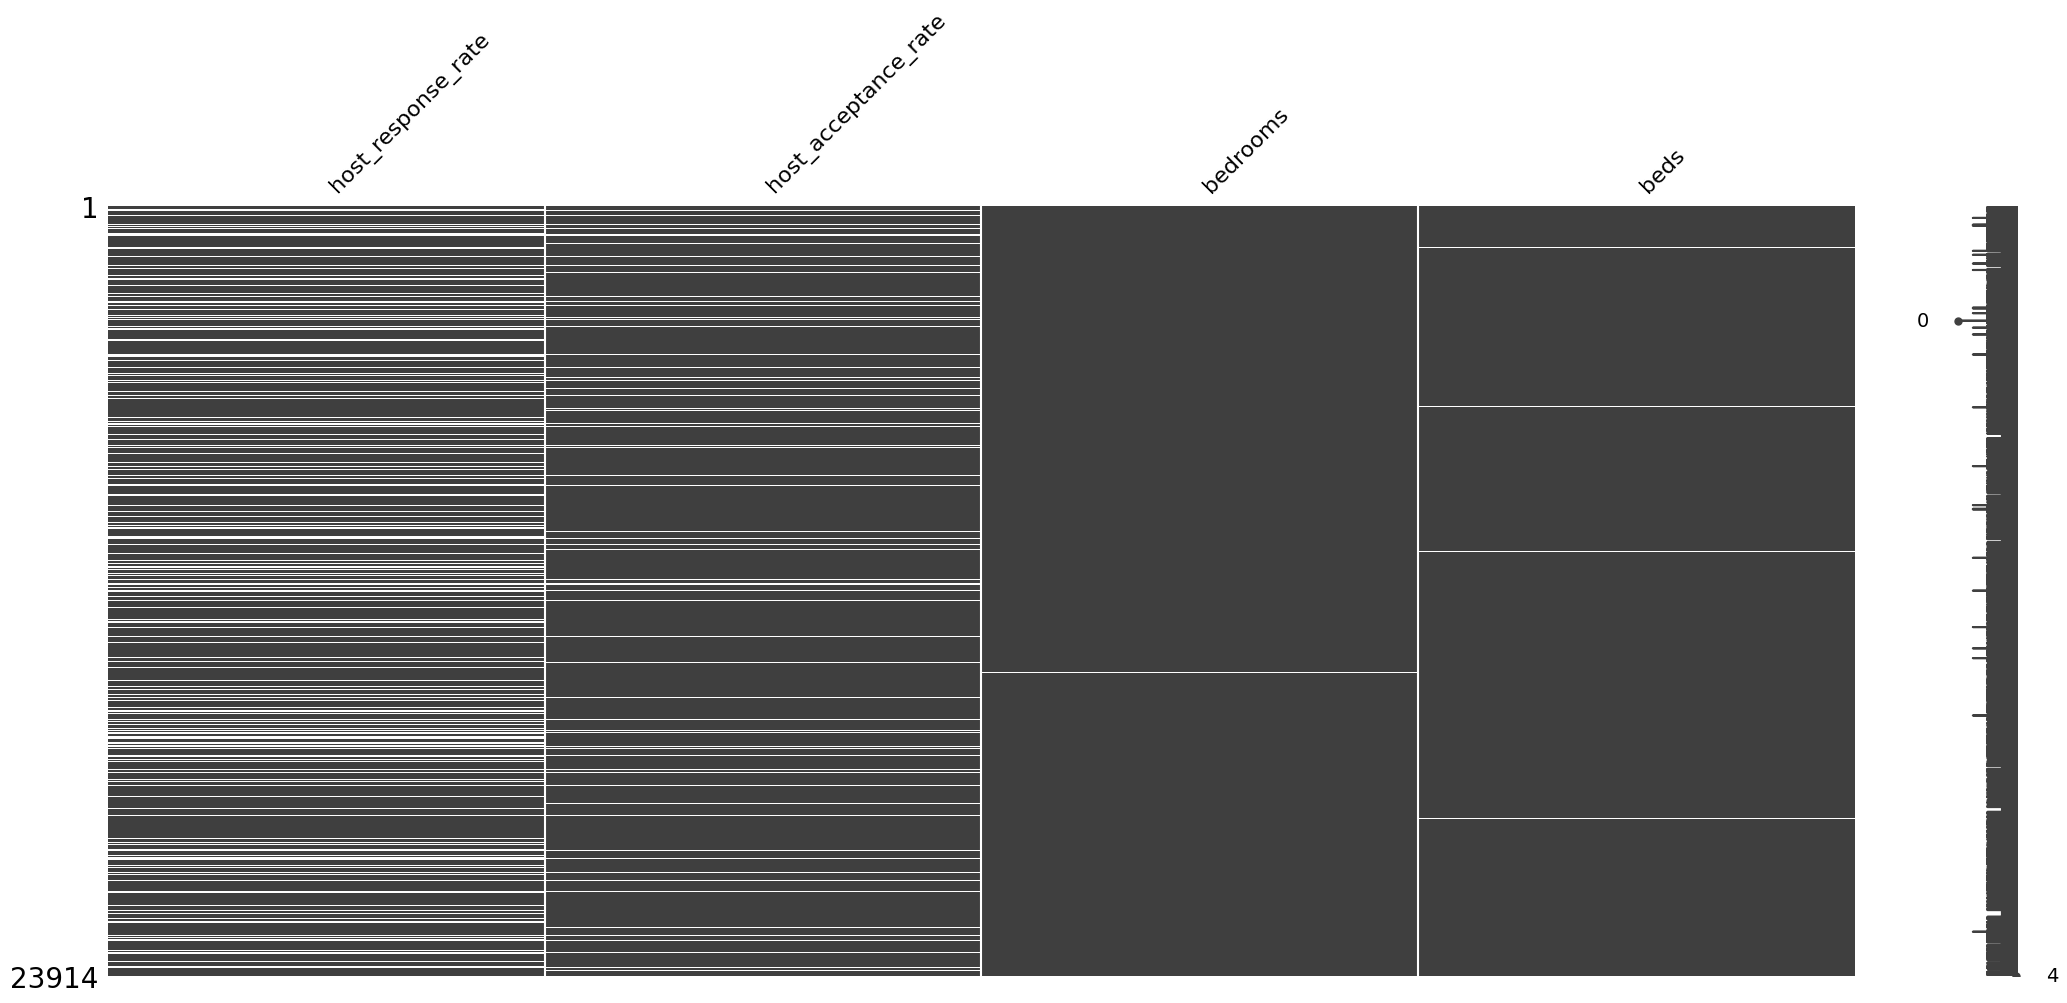

ValueError: could not convert string to float: '--'

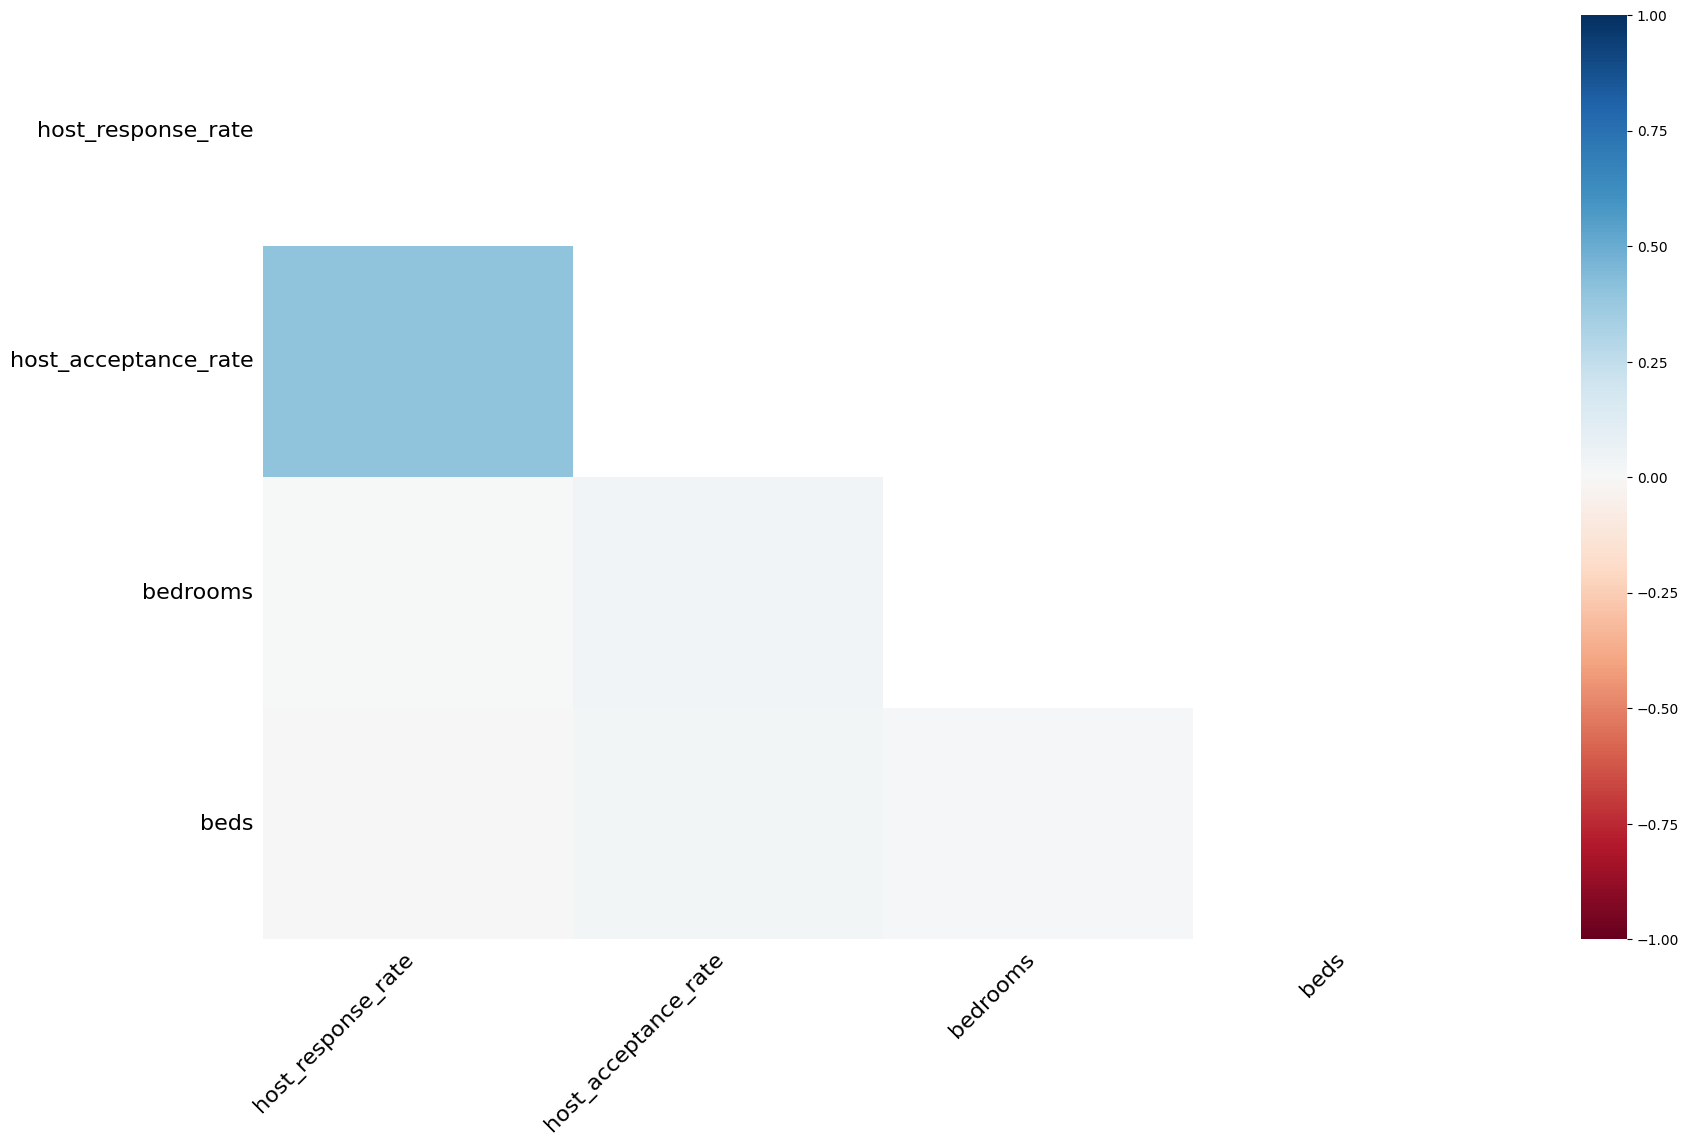

In [18]:
# Visualize the missingness matrix
msno.matrix(df2024_1[['host_response_rate','host_acceptance_rate','bedrooms','beds']])
plt.show()

# Heatmap of missingness correlation
msno.heatmap(df2024_1[['host_response_rate','host_acceptance_rate','bedrooms','beds']])
plt.show()

In [19]:
# 删除包含任何缺失值的行
df2024_1 = df2024_1.dropna(subset=['host_response_rate', 'host_acceptance_rate', 'bedrooms', 'beds'])

In [20]:
df2024_1.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calc

# Feature Engineering

## multicollinearity

In [21]:
review_score_columns = [
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]
df2024_1['review_score_mean'] = df2024_1[review_score_columns].mean(axis=1)
df2024_1.drop(review_score_columns,axis=1,inplace=True)

In [22]:
multicollinearity_drop_columns=[
    'maximum_nights_avg_ntm','availability_60','availability_90','calculated_host_listings_count','minimum_nights_avg_ntm','days_since_first_review','minimum_minimum_nights'
]
df2024_1.drop(multicollinearity_drop_columns,axis=1,inplace=True)

In [23]:
# drop outliers
numeric_cols = df2024_1.select_dtypes(include=['number'])
isolation_forest = IsolationForest(random_state = 88)

# rf_data_copy = df2024_1.copy()

# Predict the outliers, where -1 indicates an anomaly
A = isolation_forest.fit_predict(numeric_cols)

# Retrieve the indices of the rows where anomalies are located
outlier_indices = np.where(A == -1)[0]
# Drop the outliers from the dataframe
numeric_cols = numeric_cols.drop(numeric_cols.index[outlier_indices])

In [24]:
numeric_cols=numeric_cols[numeric_cols.price<100000]

In [25]:
numeric_cols.shape

(16406, 24)

In [26]:
# numeric_cols = df2024_1.select_dtypes(include=['number'])
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
# 计算VIF
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_cols.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_cols.values, i) for i in range(numeric_cols.shape[1])]

In [27]:
# 严重多重共线性
has_multiL_problem=vif_data[vif_data['VIF']>=10]
display(has_multiL_problem)

feature        VIF
0       host_response_rate  37.204860
1     host_acceptance_rate  19.016753
21  days_since_last_review  11.746381
23       review_score_mean  33.729203

## Encode Labels

In [28]:
# 将amenities的每个列表长度计算出来，作为新的特征
df2024_1['amenities_count'] = df2024_1['amenities'].apply(lambda x: len(eval(x)))

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer

# 首先，确保amenities里的每个项都是列表
df2024_1['amenities'] = df2024_1['amenities'].apply(eval)

# 使用MultiLabelBinarizer进行one-hot编码
mlb = MultiLabelBinarizer()
amenities_encoded = mlb.fit_transform(df2024_1['amenities'])
amenities_df = pd.DataFrame(amenities_encoded, columns=mlb.classes_, index=df2024_1.index)

# 将新的DataFrame合并回原始DataFrame
df = pd.concat([df2024_1, amenities_df], axis=1)

# 删除原始的amenities列
df2024_1.drop('amenities', axis=1, inplace=True)

In [30]:
label_selected_cols = [
  'host_response_time',
  'bathrooms_text'
 ]
for col in df2024_1.columns:
    if col in label_selected_cols:
        label_encoder = LabelEncoder()
        df2024_1[col]=df2024_1[col].fillna('Missing')
        df2024_1[col + '_LabelEncoded'] = label_encoder.fit_transform(df2024_1[col])
        df2024_1 = df2024_1.drop(columns=[col])

In [31]:
label_selected_cols = [
  'neighbourhood_cleansed',
  'property_type',
  'room_type'
 ]
# 1. 计算中位数和平均房价的阈值
quantiles = df2024_1['price'].quantile([0.25, 0.75])
mean_price = df2024_1['price'].mean()
median_price = df2024_1['price'].median()

# 2. 创建布尔列
df2024_1['expensive_area'] = df2024_1.groupby('neighbourhood_cleansed')['price'].transform(lambda x: x.median() > quantiles[0.75])
df2024_1['cheap_area'] = df2024_1.groupby('neighbourhood_cleansed')['price'].transform(lambda x: x.median() < quantiles[0.25])
df2024_1['expensive_property_type'] = df2024_1.groupby('property_type')['price'].transform(lambda x: x.median() > quantiles[0.75])
df2024_1['cheap_property_type'] = df2024_1.groupby('property_type')['price'].transform(lambda x: x.median() < quantiles[0.25])
df2024_1['expensive_room_type'] = df2024_1.groupby('room_type')['price'].transform(lambda x: x.median() > quantiles[0.75])
df2024_1['cheap_room_type'] = df2024_1.groupby('room_type')['price'].transform(lambda x: x.median() < quantiles[0.25])

# 3. 独热编码
df2024_1 = pd.get_dummies(df2024_1, columns=label_selected_cols)

# 4. 删除True个数小于5的列
for col in df2024_1.columns:
    if df2024_1[col].dtype == 'uint8' and df2024_1[col].sum() < 10:
        df2024_1.drop(col, axis=1, inplace=True)

## Outlies

In [32]:
# drop outliers
isolation_forest = IsolationForest(random_state = 88)

# rf_data_copy = df2024_1.copy()

# Predict the outliers, where -1 indicates an anomaly
A = isolation_forest.fit_predict(df2024_1)

# Retrieve the indices of the rows where anomalies are located
outlier_indices = np.where(A == -1)[0]
# Drop the outliers from the dataframe
df2024_1 = df2024_1.drop(df2024_1.index[outlier_indices])

In [33]:
df2024_1=df2024_1[df2024_1.price<100000]

In [34]:
df2024_1.shape

(18042, 314)

# Models

- 未进行特征选择的模型测试：(模型：xg_reg，rf)
- 使用随机森林进行特征选择后的模型(模型：best_rf_XGB,best_rf_rf)
- 使用XGBoost进行特征选择后的模型(模型：best_xgb_XGB,best_xgb_rf)
- PCA降维后的模型(模型：best_pca_XGB,best_pca_rf)



## Standardization

In [35]:
# X = df2024_1.drop(['price'],axis=1)
features = df2024_1.drop(['price'], axis=1)  # 选择特征列
scaler = preprocessing.StandardScaler().fit(features)  # 拟合scaler

# 使用拟合的scaler来变换数据
X_scaled = scaler.transform(features)

# 创建一个新的DataFrame，用变换后的数据和原来的列名
X = pd.DataFrame(X_scaled, columns=features.columns)
y = np.log(df2024_1[['price']])
# y = df2024_1[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [36]:
from sklearn.metrics import mean_absolute_percentage_error

def scores(X_train, X_test, y_train, y_test, model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # 计算R2
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    # 计算训练集上的MSE和RMSE
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    # 计算测试集上的MSE和RMSE
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    # 计算训练集和测试集上的MAPE
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"Train R2 score: {train_score}, Test R2 score {test_score}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train MAPE: {train_mape}, Test MAPE: {test_mape}")

# 用你的模型实例替换'model'
# scores(X_train, X_test, y_train, y_test, model)


In [37]:
def n_r2score_plot(estimators,mod,X_train, X_test, y_train, y_test):
#     estimators: a list of number
#     mod: 0-XGBoost, 1 - random forest

    train_scores = []
    test_scores = []
    for n in estimators:
        if mod==1:
            model = RandomForestRegressor(n_estimators=n, random_state=42,n_jobs=-1)
        else:
            model = xgb.XGBRegressor(n_estimators=n, random_state=42,n_jobs=-1)
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_scores.append(r2_score(y_train, train_pred))
        test_scores.append(r2_score(y_test, test_pred))

    # 绘制线图
    plt.figure(figsize=(10, 6))
    plt.plot(estimators, train_scores, label='Training R2 Score')
    plt.plot(estimators, test_scores, label='Testing R2 Score')
    plt.xlabel('Number of Estimators')
    plt.ylabel('R2 Score')
    plt.title('R2 Score vs. Number of Estimators')
    plt.legend()
    plt.grid(True)
    plt.show()

In [38]:
def grid_tune(param_grid, mod, ver, X_train, y_train):
    # 选择模型
    if mod == 0:
        model = xgb.XGBRegressor(random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)

    # 初始化网格搜索对象
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='r2', cv=5, verbose=ver, n_jobs=-1)

    # 执行网格搜索
    grid_search.fit(X_train, y_train)  # 使用正确的变量

    # 打印最优参数和对应的评估分数
    print("Best parameters found: ", grid_search.best_params_)
    print("Best R2 Score: ", grid_search.best_score_)

    return grid_search.best_estimator_

In [39]:
def feature_importance_ranking(model, columns):
    feature_importances = model.feature_importances_

    # 将特征重要性转换为DataFrame以方便绘图
    features_df = pd.DataFrame({'Features': columns, 'Importance Score': feature_importances})
    features_df = features_df.sort_values(by='Importance Score', ascending=False)

    # 绘制特征重要性条形图
    plt.figure(figsize=(50,50))
    sns.barplot(x='Importance Score', y='Features', data=features_df)
    plt.title(f'Feature Importances')
    plt.show()

## test on XGBoost

In [40]:
# 初始化XGBoost回归模型
xg_reg = xgb.XGBRegressor(random_state=42)
xg_reg.fit(X_train, y_train)

scores(X_train,X_test,y_train,y_test,xg_reg)

Train R2 score: 0.8943535034074747, Test R2 score 0.7929831949642622
Train MSE: 0.06571374046171408, Test MSE: 0.13394795715118368
Train RMSE: 0.2563469142816314, Test RMSE: 0.36598901233668707
Train MAPE: 0.038615142049466006, Test MAPE: 0.053896513606461145


## test on random forest

In [41]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

scores(X_train,X_test,y_train,y_test,rf)

Train R2 score: 0.969425091323932, Test R2 score 0.7897904263349127
Train MSE: 0.01901806191575975, Test MSE: 0.13601380313641145
Train RMSE: 0.137905989412207, Test RMSE: 0.36880049232127043
Train MAPE: 0.018996956249885552, Test MAPE: 0.05271819157880829


When the $R^2$ score on the training data is significantly higher than the $R^2$ score on the test data, it indicates that the model is overfitting.

## feature selection-RF

In [42]:
# 打印特征重要性
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# 选择重要性得分高于平均水平的特征
sfm = SelectFromModel(rf, threshold='median', prefit=True)
X_train_rf_selected = sfm.transform(X_train)
X_test_rf_selected = sfm.transform(X_test)

In [43]:
# 获取选中的特征的布尔掩码
selected_mask = sfm.get_support()

# 打印被选中的特征名称
selected_features = X_train.columns[selected_mask]
print("Selected features:", selected_features)

Selected features: Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       ...
       'property_type_Room in aparthotel',
       'property_type_Room in boutique hotel', 'property_type_Room in hotel',
       'property_type_Shared room in home',
       'property_type_Shared room in loft',
       'property_type_Shared room in rental unit', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object', length=157)


### baseline model-XGBoost

In [44]:
# 初始化XGBoost回归模型
xg_reg_rf_features = xgb.XGBRegressor(random_state=42)
xg_reg_rf_features.fit(X_train_rf_selected, y_train)
scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,xg_reg_rf_features)

Train R2 score: 0.9091036780801113, Test R2 score 0.7969816792510047
Train MSE: 0.05653890569231228, Test MSE: 0.13136078167130993
Train RMSE: 0.2377791111353398, Test RMSE: 0.3624372796378843
Train MAPE: 0.03616707115940416, Test MAPE: 0.05288257501953279


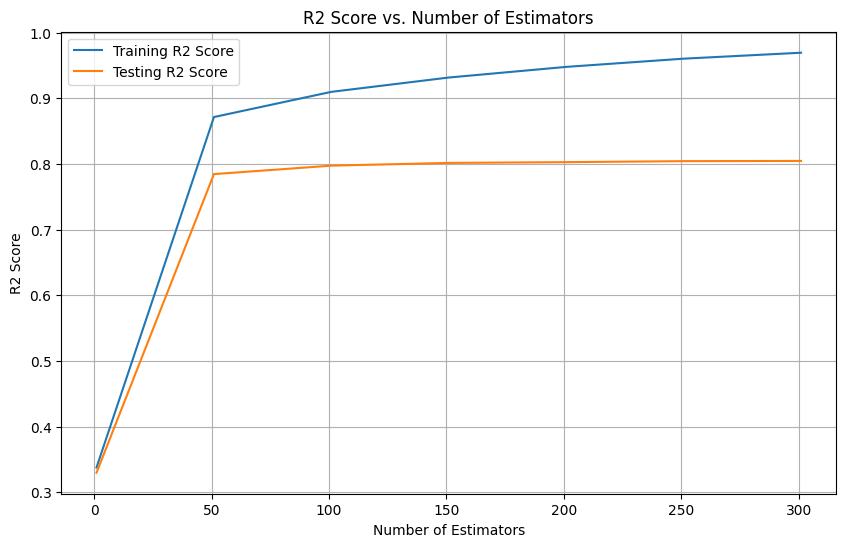

In [45]:
n_r2score_plot(range(1,302,50),0,X_train_rf_selected,X_test_rf_selected,y_train,y_test)

In [46]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [100,200,250],
    'min_child_weight':range(2,5),
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1]
}
best_rf_XGB = grid_tune(param_grid, 0, 2, X_train_rf_selected, y_train)
scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,best_rf_XGB)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWar

Best parameters found:  {'min_child_weight': 2, 'n_estimators': 250, 'reg_alpha': 1, 'reg_lambda': 0.01}
Best R2 Score:  0.8030027193324024
Train R2 score: 0.9591806412457266, Test R2 score 0.8019581371480191
Train MSE: 0.025390266913798493, Test MSE: 0.12814081907436578
Train RMSE: 0.1593432361721027, Test RMSE: 0.35796762294146905
Train MAPE: 0.02395552020764349, Test MAPE: 0.05183492611032383


### baseline model-RF

In [47]:
# baseline model
rf_rf_features = RandomForestRegressor(random_state=42)
rf_rf_features.fit(X_train_rf_selected, y_train)

scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,rf_rf_features)

Train R2 score: 0.9695392820494647, Test R2 score 0.7888881357862115
Train MSE: 0.018947033533912493, Test MSE: 0.13659762035711714
Train RMSE: 0.13764822386762748, Test RMSE: 0.3695911529746311
Train MAPE: 0.018947104027511603, Test MAPE: 0.05282277973237559


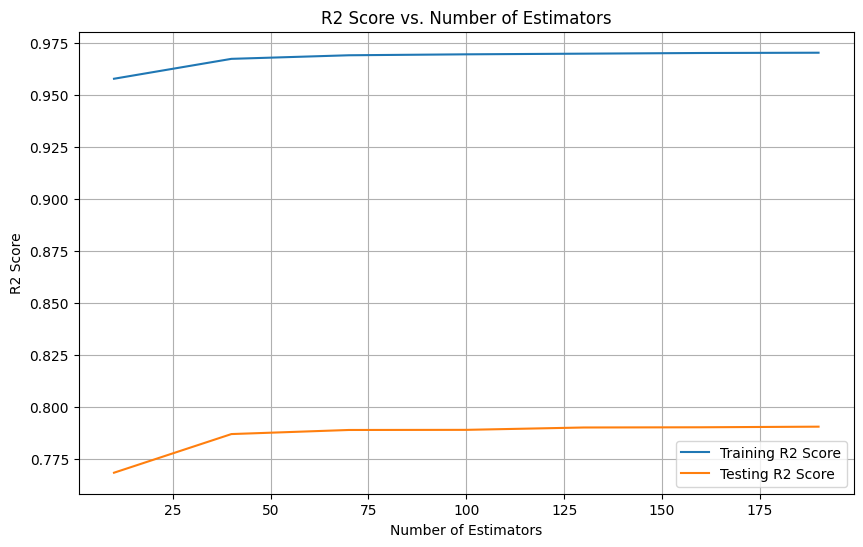

In [48]:
n_r2score_plot(range(10,201,30),1,X_train_rf_selected,X_test_rf_selected,y_train,y_test)

In [49]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [110,180,250],
#     'max_depth': [10, 20]
    'min_samples_split': [2, 5, 10]
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
}
best_rf_rf = grid_tune(param_grid, 1, 2, X_train_rf_selected, y_train)
scores(X_train_rf_selected,X_test_rf_selected,y_train,y_test,best_rf_rf)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/simaochen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/simaochen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/simaochen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/simaochen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

KeyboardInterrupt: 

## feature selection-XGBoost

In [ ]:
# 使用内置的特征重要性
selection = SelectFromModel(xg_reg, prefit=True, threshold='median')  # threshold可以是具体的数值或者字符串，如'median'
X_train_XGB_selected = selection.transform(X_train)
X_test_XGB_selected = selection.transform(X_test)


# 查看被选中的特征数量
selected_features_count = X_train_XGB_selected.shape[1]
# 获取被选中的特征名
selected_features = X_train.columns[(selection.get_support())]

# 打印被选中的特征名
print("Selected features:", selected_features)

### baseline model-XGBoost

In [ ]:
# 初始化XGBoost回归模型
xg_reg_xg_features = xgb.XGBRegressor(random_state=42)
xg_reg_xg_features.fit(X_train_XGB_selected, y_train)
scores(X_train_XGB_selected,X_test_XGB_selected,y_train,y_test,xg_reg_xg_features)

In [ ]:
n_r2score_plot(range(1,302,50),0,X_train_XGB_selected,X_test_XGB_selected,y_train,y_test)

In [ ]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [100,200,250],
    'min_child_weight':range(2,5),
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1]
}
best_xgb_XGB = grid_tune(param_grid, 0, 2, X_train_XGB_selected,y_train)
scores(X_train_XGB_selected, X_test_XGB_selected,y_train,y_test,best_xgb_XGB)

### baseline model-RF

In [ ]:
# baseline model
rf_rf_features = RandomForestRegressor(random_state=42)
rf_rf_features.fit(X_train_XGB_selected, y_train)

scores(X_train_XGB_selected,X_test_XGB_selected,y_train,y_test,rf_rf_features)

In [ ]:
n_r2score_plot(range(10,201,30),1,X_train_XGB_selected,X_test_XGB_selected,y_train,y_test)

In [ ]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [110,150,200,300],
#     'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
}
best_rf_rf = grid_tune(param_grid, 1, 2, X_train_XGB_selected,y_train)
scores(X_train_XGB_selected,X_test_XGB_selected,y_train,y_test,best_rf_rf)

## feature selection-PCA

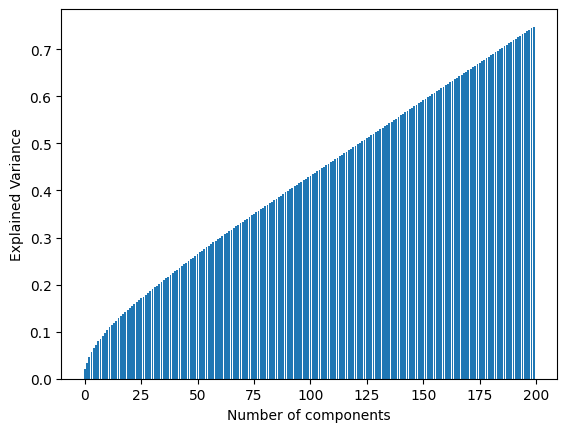

In [50]:
#plot explained variance over the number of compinents
# try to find a best component num
pca = PCA(X.shape[1])
X_S=pca.fit_transform(X)
eigenvalues = pca.explained_variance_ratio_
n= 200
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [51]:
bestPCA = PCA(106)
X_PCA_S_after=bestPCA.fit_transform(X)
X_PCA_S_after.shape

(18042, 106)

In [52]:
components = pd.DataFrame(bestPCA.components_,columns=X.columns)
top_features = components.abs().idxmax(axis=1)

In [53]:
print(top_features)

0                              cheap_room_type
1                            reviews_per_month
2                  property_type_Room in hotel
3                                     bedrooms
4                        room_type_Shared room
                        ...                   
101          neighbourhood_cleansed_Grant City
102         neighbourhood_cleansed_Eltingville
103        neighbourhood_cleansed_New Brighton
104       neighbourhood_cleansed_Arden Heights
105    neighbourhood_cleansed_Roosevelt Island
Length: 106, dtype: object


In [54]:
X_train_PCA_selected, X_test_PCA_selected, y_train, y_test = train_test_split(X_PCA_S_after, y, test_size=0.2, random_state=99)

### baseline model-XGBoost

In [55]:
# 初始化XGBoost回归模型
xg_reg_pca_features = xgb.XGBRegressor(random_state=42)
xg_reg_pca_features.fit(X_train_PCA_selected, y_train)
scores(X_train_PCA_selected,X_test_PCA_selected,y_train,y_test,xg_reg_pca_features)

Train R2 score: 0.9555134452056637, Test R2 score 0.7437890649156939
Train MSE: 0.027671319069539957, Test MSE: 0.16577848039154497
Train RMSE: 0.1663469839508368, Test RMSE: 0.4071590357483731
Train MAPE: 0.025402618148857695, Test MAPE: 0.0599649507786023


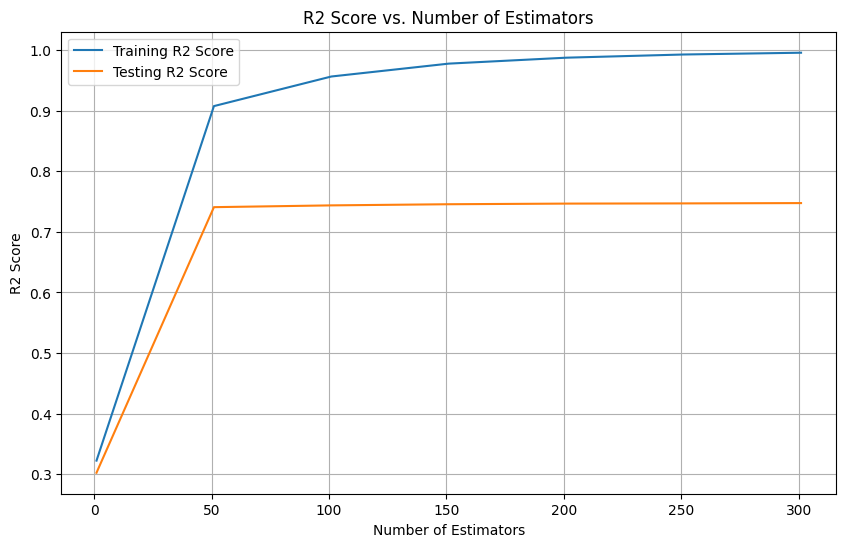

In [56]:
n_r2score_plot(range(1,302,50),0,X_train_PCA_selected,X_test_PCA_selected,y_train,y_test)

In [57]:
# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [50,100,200,300],
#     'min_child_weight':range(2,6),
    'reg_alpha': [0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.001, 0.01, 0.1, 1]
}
best_pca_XGB = grid_tune(param_grid, 0, 2, X_train_PCA_selected,y_train)
scores(X_train_PCA_selected,X_test_PCA_selected,y_train,y_test,best_pca_XGB)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/simaochen/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWar

KeyboardInterrupt: 

### baseline model-RF

In [58]:
# baseline model
pca_rf_features = RandomForestRegressor(random_state=42,n_jobs=-1)
pca_rf_features.fit(X_train_PCA_selected, y_train)

scores(X_train_PCA_selected,X_test_PCA_selected,y_train,y_test,pca_rf_features)

Train R2 score: 0.964545548129994, Test R2 score 0.750802936111017
Train MSE: 0.02205321258672711, Test MSE: 0.16124023182678293
Train RMSE: 0.148503240997384, Test RMSE: 0.40154729712299514
Train MAPE: 0.02112669745449799, Test MAPE: 0.05820573899993194


In [ ]:
n_r2score_plot([10,50,100],1,X_train_PCA_selected,X_test_PCA_selected,y_train,y_test)

# Results

<tbody><tr height="29.50" style="height:14.75pt;">
    <td class="xl66" height="63" width="301" rowspan="2" style="height:31.50pt;width:150.50pt;border-right:.5pt solid #000000;border-bottom:1.5pt solid #000000;" x:str="">feature selection method</td>
    <td class="xl67" width="169" rowspan="2" style="width:84.50pt;border-right:.5pt solid windowtext;border-bottom:1.5pt solid windowtext;" x:str="">model</td>
    <td class="xl68" width="387.20" colspan="4" style="width:193.60pt;border-right:.5pt solid windowtext;border-bottom:.5pt solid windowtext;" x:str="">training data</td>
    <td class="xl69" width="387.20" colspan="4" style="width:193.60pt;border-right:none;border-bottom:.5pt solid windowtext;" x:str="">testing data</td>
   </tr>
   <tr height="33.50" style="height:16.75pt;">
    <td class="xl72" x:str="">R<font class="font20"><sup>2</sup></font></td>
    <td class="xl73" x:str="">MSE</td>
    <td class="xl73" x:str="">RMSE</td>
    <td class="xl74" x:str="">MAPE</td>
    <td class="xl74" x:str="">R<font class="font20"><sup>2</sup></font></td>
    <td class="xl73" x:str="">MSE</td>
    <td class="xl73" x:str="">RMSE</td>
    <td class="xl84" x:str="">MAPE</td>
   </tr>
   <tr height="29.50" style="height:14.75pt;">
    <td class="xl75" height="57.50" rowspan="2" style="height:28.75pt;border-right:.5pt solid #000000;border-bottom:.5pt solid #000000;" x:str="">None</td>
    <td class="xl76" x:str="">Random Forest</td>
    <td class="xl77" x:num="0.969477097554718">0.9695<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.8985713242944999e-002">0.0190<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.137788654260592">0.1378<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.89932184698209e-002">0.0190<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.78839709528516499">0.7884<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13691534273710501">0.1369<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.37002073284764098">0.3700<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.2893995960203798e-002">0.0529<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl79" x:str="">XGBoost</td>
    <td class="xl77" x:num="0.90186601740525396">0.9019<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="6.1040841586807101e-002">0.0610<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.24706444824540599">0.2471<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="3.7078397819275598e-002">0.0371<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.79528541562614496">0.7953<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13245833047803801">0.1325<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.36394825247284601">0.3639<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.3604520571596197e-002">0.0536<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl78" height="56" rowspan="2" style="height:28.00pt;border-right:.5pt solid #000000;border-bottom:.5pt solid #000000;" x:str="">Random Forest</td>
    <td class="xl79" x:str="">Random Forest</td>
    <td class="xl77" x:num="0.97045432094684303">0.9705<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.8377865312020202e-002">0.0184<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13556498556788199">0.1356<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.8791229486821999e-002">0.0188<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.79006720547704701">0.7901<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13583471622284099">0.1358<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.36855761587958102">0.3686<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.2779839311995098e-002">0.0528<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl79" x:str="">XGBoost</td>
    <td class="xl77" x:num="0.95916670922940095">0.9592<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.5398932841533401e-002">0.0254<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.15937042649605099">0.1594<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.3994947118946099e-002">0.0240<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.806823317883545">0.8068<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.12499285714643101">0.1250<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.35354328892857201">0.3535<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.1874613365576798e-002">0.0519<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl78" height="56" rowspan="2" style="height:28.00pt;border-right:.5pt solid #000000;border-bottom:.5pt solid #000000;" x:str="">XGBoost</td>
    <td class="xl79" x:str="">Random Forest</td>
    <td class="xl77" x:num="0.97046445956826999">0.9705<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.83715589340653e-002">0.0184<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.13554172396006001">0.1355<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="1.8805524967112599e-002">0.0188<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.78870758840334998">0.7887<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.136714441564453">0.1367<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.36974916032961203">0.3697<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.28093060807385e-002">0.0528<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl79" x:str="">XGBoost</td>
    <td class="xl77" x:num="0.94606001421715802">0.9461<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="3.3551498067310101e-002">0.0336<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.18317068015190099">0.1832<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.7619874505555201e-002">0.0276<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.80614071094311002">0.8061<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.12543453049363901">0.1254<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.35416737638246598">0.3542<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.1820144450738299e-002">0.0518<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="28" style="height:14.00pt;">
    <td class="xl78" height="57.50" rowspan="2" style="height:28.75pt;border-right:.5pt solid #000000;border-bottom:1.0pt solid #000000;" x:str="">PCA</td>
    <td class="xl79" x:str="">Random Forest</td>
    <td class="xl77" x:num="0.96533238019793799">0.9653<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.1563790978178201e-002">0.0216<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.14684614730451101">0.1468<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="2.0874986769144e-002">0.0209<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.75569232904895101">0.7557<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.15807660365837001">0.1581<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="0.39758848531914298">0.3976<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl77" x:num="5.7770564501017203e-002">0.0578<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <tr height="29.50" style="height:14.75pt;">
    <td class="xl81" x:str="">XGBoost</td>
    <td class="xl82" x:num="0.98064158860726702">0.9806<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="1.20412286544592e-002">0.0120<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="0.109732532343235">0.1097<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="1.6550728801952099e-002">0.0166<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="0.75284821189042705">0.7528<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="0.159916858526651">0.1599<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="0.39989605965381902">0.3999<span style="mso-spacerun:yes;">&nbsp;</span></td>
    <td class="xl82" x:num="5.8608146146855403e-002">0.0586<span style="mso-spacerun:yes;">&nbsp;</span></td>
   </tr>
   <!--[if supportMisalignedColumns]-->
    <tr width="0" style="display:none;">
     <td width="301" style="width:151;"></td>
     <td width="169" style="width:85;"></td>
     <td width="97" style="width:48;"></td>
    </tr>
   <!--[endif]-->
  </tbody>

Train R2 score: -39.96383897853607, Test R2 score -37.813799475778715 \
Train MSE: 25.64567077863455, Test MSE: 25.375530184328255 \
Train RMSE: 5.064155485234883, Test RMSE: 5.037413044840402 \
Train MAPE: 1.0284420758814283, Test MAPE: 1.028554229214467 \

## Neural Nets
### Part 1: data processing following the previous data cleaning and analysis

In [108]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_PCA_S_after, y, test_size=0.1, random_state=99)

In [109]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=99)

In [110]:
type(X_train)

numpy.ndarray

In [111]:
# another way to fill nan
X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train))
X_val= np.nan_to_num(X_val, nan=np.nanmean(X_val))
X_test = np.nan_to_num(X_test, nan=np.nanmean(X_test))

y_train = np.nan_to_num(y_train, nan=np.nanmean(y_train))
y_val = np.nan_to_num(y_val, nan=np.nanmean(y_val))
y_test = np.nan_to_num(y_test, nan=np.nanmean(y_test))



In [112]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64

# data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [113]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [114]:
type(val_dataset)

torch.utils.data.dataset.TensorDataset

In [115]:
type(test_dataset)

torch.utils.data.dataset.TensorDataset

In [118]:
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)


X_train_tensor shape: torch.Size([13801, 106])
y_train_tensor shape: torch.Size([13801, 1])


In [120]:
print("X_val_tensor shape:", X_val_tensor.shape)
print("y_val_tensor shape:", y_val_tensor.shape)

X_val_tensor shape: torch.Size([2436, 106])
y_val_tensor shape: torch.Size([2436, 1])


In [121]:
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)


X_test_tensor shape: torch.Size([1805, 106])
y_test_tensor shape: torch.Size([1805, 1])


### Part 2: Experiment designs and implementations

### We use 4 models: 
### 1. Basic 5 layers
### 2. Basic 5 layers with Dropout
### 3. Basic 5 layers with Batch Normalization
### 4. Advanced with 9 layers

### We first use 4 different combinations of learning rate scedulers and optimizers on Basic 5 Layer. Then we use the best combinations of hyperparameters on the rest 3 different architetures. In conlusion, we have 7 different comparable experiments in the following with train and validation losses, and train and validation accuracies metrics and graphs. We conclude that the 5 basic layer architecture with the first set of hyperparameters is the best model in our experiments with our chosen data to predict airbnb pricing for the next month: 

In [122]:
class AirbnbPricePredictor(nn.Module):
    def __init__(self, input_size):
        super(AirbnbPricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  
        self.fc2 = nn.Linear(256, 128)       
        self.fc3 = nn.Linear(128, 64)          
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [123]:
class AirbnbPricePredictorDO(nn.Module):
    def __init__(self, input_size, dropout_prob=0.5):
        super(AirbnbPricePredictorDO, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(dropout_prob) 
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout_prob) 
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(dropout_prob)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) 
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  
        x = F.relu(self.fc3(x))
        x = self.dropout3(x) 
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


In [73]:
class AirbnbPricePredictorBN(nn.Module):
    def __init__(self, input_size):
        super(AirbnbPricePredictorBN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [124]:
class AirbnbPricePredictor9Layer(nn.Module):
    def __init__(self, input_size):
        super(AirbnbPricePredictor9Layer, self).__init__()
        self.fc1 = nn.Linear(input_size, 256) 
        self.fc2 = nn.Linear(256, 512)    
        self.fc3 = nn.Linear(512, 1024)        
        self.fc4 = nn.Linear(1024, 512)       
        self.fc5 = nn.Linear(512, 256)       
        self.fc6 = nn.Linear(256, 128)         
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 32)
        self.fc9 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = self.fc9(x)
        return x

# NN Experiment 1 :

## Experiment 1-4 are different sets of hyperparameters with this same basci architecture.

## This set of the hyperparameters from experiment is the (slight)winner for this basic 5-layer architecture, and we will use this set to test on different architectures later (From Experiment 5, we start to experiment with different architectures)

## Hyperparameters: 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically L1 Loss (Mean Absolute Error) with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: Learning rate scheduler using StepLR method, with a step size of 50 epochs and a gamma value of 0.1.
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 

- **Hit almost 82% val acc around epoch 50, where train acc hits 93% around epoch 100**

In [75]:
input_size = X_train_tensor.shape[1]
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')  # Using L1Loss for Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 100
threshold = 0.1  # 10% threshold

In [76]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 2.1159, Val Loss: 0.8608, Training Accuracy: 24.90%, Validation Accuracy: 52.09%
Epoch 2/100, Loss: 0.6448, Val Loss: 0.5291, Training Accuracy: 58.90%, Validation Accuracy: 65.80%
Epoch 3/100, Loss: 0.4412, Val Loss: 0.4212, Training Accuracy: 69.22%, Validation Accuracy: 72.25%
Epoch 4/100, Loss: 0.3776, Val Loss: 0.3976, Training Accuracy: 73.32%, Validation Accuracy: 72.41%
Epoch 5/100, Loss: 0.3482, Val Loss: 0.3806, Training Accuracy: 76.02%, Validation Accuracy: 74.01%
Epoch 6/100, Loss: 0.3326, Val Loss: 0.3684, Training Accuracy: 77.68%, Validation Accuracy: 75.90%
Epoch 7/100, Loss: 0.3239, Val Loss: 0.3609, Training Accuracy: 78.35%, Validation Accuracy: 76.27%
Epoch 8/100, Loss: 0.3158, Val Loss: 0.3512, Training Accuracy: 79.37%, Validation Accuracy: 77.09%
Epoch 9/100, Loss: 0.3064, Val Loss: 0.3559, Training Accuracy: 80.08%, Validation Accuracy: 77.01%
Epoch 10/100, Loss: 0.3022, Val Loss: 0.3408, Training Accuracy: 80.73%, Validation Accuracy: 78.00%

Epoch 83/100, Loss: 0.1882, Val Loss: 0.3045, Training Accuracy: 92.52%, Validation Accuracy: 82.22%
Epoch 84/100, Loss: 0.1874, Val Loss: 0.3184, Training Accuracy: 92.36%, Validation Accuracy: 80.71%
Epoch 85/100, Loss: 0.1849, Val Loss: 0.3100, Training Accuracy: 92.64%, Validation Accuracy: 81.03%
Epoch 86/100, Loss: 0.1879, Val Loss: 0.3038, Training Accuracy: 92.48%, Validation Accuracy: 81.20%
Epoch 87/100, Loss: 0.1854, Val Loss: 0.3029, Training Accuracy: 92.53%, Validation Accuracy: 81.81%
Epoch 88/100, Loss: 0.1842, Val Loss: 0.3097, Training Accuracy: 92.81%, Validation Accuracy: 81.16%
Epoch 89/100, Loss: 0.1874, Val Loss: 0.3085, Training Accuracy: 92.63%, Validation Accuracy: 81.20%
Epoch 90/100, Loss: 0.1828, Val Loss: 0.3089, Training Accuracy: 92.86%, Validation Accuracy: 80.87%
Epoch 91/100, Loss: 0.1825, Val Loss: 0.3033, Training Accuracy: 92.86%, Validation Accuracy: 82.31%
Epoch 92/100, Loss: 0.1834, Val Loss: 0.3101, Training Accuracy: 92.58%, Validation Accurac

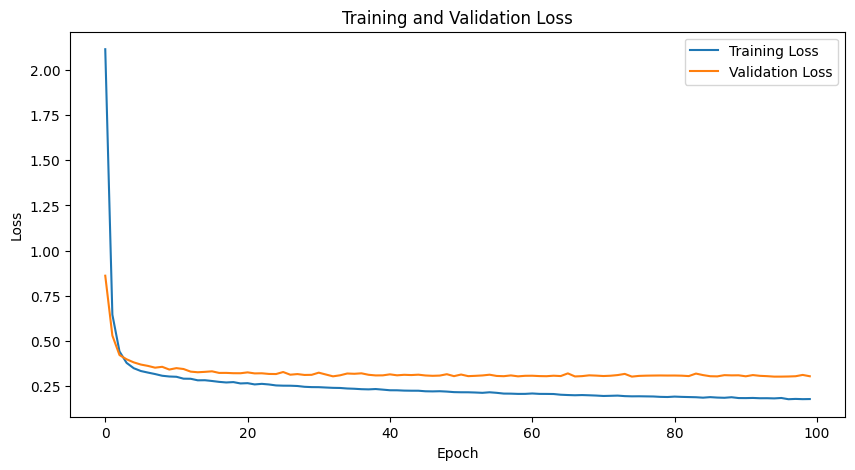

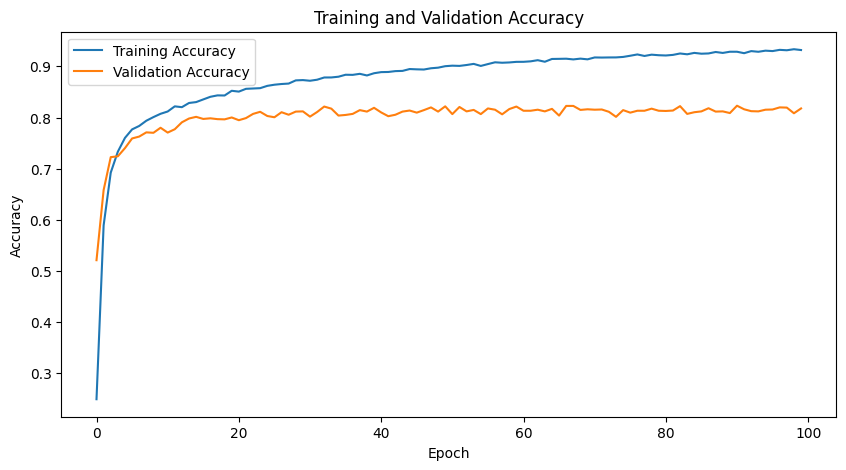

In [80]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# NN Experiment 2: 

## Hyperparameters: 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically nn.MSELoss() with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: No specifict learning rate scheduler set, with the constant 0.0002 lr. 
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 
- **Hit almost 82% val acc around epoch 50, where train acc hits 93% around epoch 100** (Best so far)
- **Hit 80% val acc around epoch 25, where train acc hits 95% around epoch 100, indicating some overfitting** (Currently)

In [81]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)

criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0002)
threshold = 0.1

106


In [82]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 8.1052, Val Loss: 3.3220, Training Accuracy: 9.16%, Validation Accuracy: 18.84%
Epoch 2/100, Loss: 1.5771, Val Loss: 1.1125, Training Accuracy: 38.30%, Validation Accuracy: 52.59%
Epoch 3/100, Loss: 0.5412, Val Loss: 0.6159, Training Accuracy: 56.84%, Validation Accuracy: 63.59%
Epoch 4/100, Loss: 0.3320, Val Loss: 0.4789, Training Accuracy: 65.65%, Validation Accuracy: 67.36%
Epoch 5/100, Loss: 0.2717, Val Loss: 0.4109, Training Accuracy: 69.71%, Validation Accuracy: 70.24%
Epoch 6/100, Loss: 0.2447, Val Loss: 0.3931, Training Accuracy: 72.07%, Validation Accuracy: 71.80%
Epoch 7/100, Loss: 0.2265, Val Loss: 0.3743, Training Accuracy: 73.63%, Validation Accuracy: 73.60%
Epoch 8/100, Loss: 0.2158, Val Loss: 0.3708, Training Accuracy: 74.89%, Validation Accuracy: 73.11%
Epoch 9/100, Loss: 0.2056, Val Loss: 0.3734, Training Accuracy: 75.91%, Validation Accuracy: 74.75%
Epoch 10/100, Loss: 0.1951, Val Loss: 0.3385, Training Accuracy: 76.89%, Validation Accuracy: 75.86%


Epoch 83/100, Loss: 0.0640, Val Loss: 0.3339, Training Accuracy: 94.75%, Validation Accuracy: 79.19%
Epoch 84/100, Loss: 0.0674, Val Loss: 0.3295, Training Accuracy: 94.54%, Validation Accuracy: 80.17%
Epoch 85/100, Loss: 0.0633, Val Loss: 0.3274, Training Accuracy: 95.07%, Validation Accuracy: 80.46%
Epoch 86/100, Loss: 0.0652, Val Loss: 0.3082, Training Accuracy: 94.88%, Validation Accuracy: 79.23%
Epoch 87/100, Loss: 0.0630, Val Loss: 0.3337, Training Accuracy: 95.20%, Validation Accuracy: 80.13%
Epoch 88/100, Loss: 0.0638, Val Loss: 0.3134, Training Accuracy: 94.98%, Validation Accuracy: 80.34%
Epoch 89/100, Loss: 0.0625, Val Loss: 0.3204, Training Accuracy: 95.17%, Validation Accuracy: 79.52%
Epoch 90/100, Loss: 0.0630, Val Loss: 0.3293, Training Accuracy: 95.17%, Validation Accuracy: 80.34%
Epoch 91/100, Loss: 0.0624, Val Loss: 0.3453, Training Accuracy: 95.10%, Validation Accuracy: 79.80%
Epoch 92/100, Loss: 0.0609, Val Loss: 0.3135, Training Accuracy: 95.40%, Validation Accurac

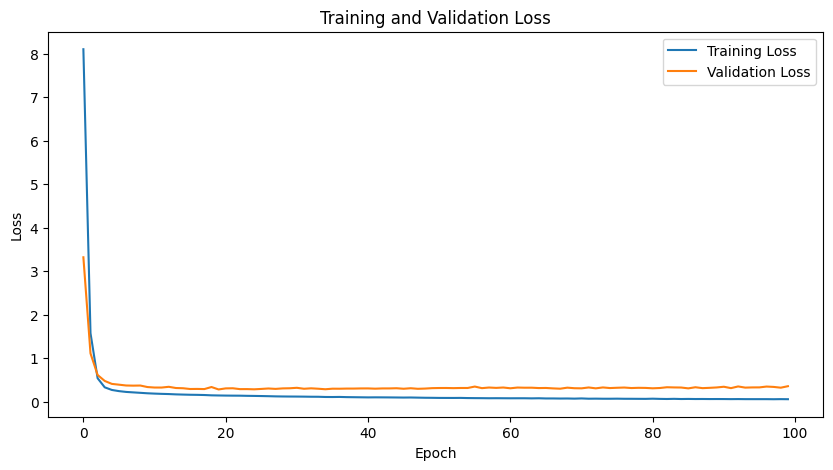

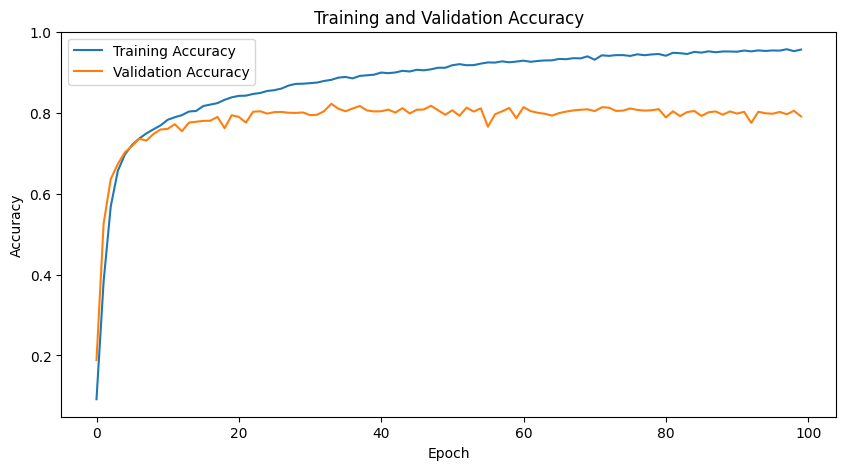

In [83]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# NN Experiment 3: 

## Hyperparameters: 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically nn.L1Loss with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0001.
- **scheduler**: No specifict learning rate scheduler set, with the constant 0.0001 lr. 
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 
- **Hit almost 82% val acc around epoch 50, where train acc hits 93% around epoch 100** (Best so far)
- **Hit 80% val acc around epoch 57, where train acc hits 91% around epoch 100** (Currently)

In [84]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')
# criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
threshold = 0.1

106


In [85]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 2.9201, Val Loss: 1.2080, Training Accuracy: 10.83%, Validation Accuracy: 36.66%
Epoch 2/100, Loss: 0.9449, Val Loss: 0.8264, Training Accuracy: 47.55%, Validation Accuracy: 54.15%
Epoch 3/100, Loss: 0.6917, Val Loss: 0.6374, Training Accuracy: 57.12%, Validation Accuracy: 62.36%
Epoch 4/100, Loss: 0.5398, Val Loss: 0.5237, Training Accuracy: 64.64%, Validation Accuracy: 67.98%
Epoch 5/100, Loss: 0.4512, Val Loss: 0.4584, Training Accuracy: 69.28%, Validation Accuracy: 72.04%
Epoch 6/100, Loss: 0.3991, Val Loss: 0.4291, Training Accuracy: 72.94%, Validation Accuracy: 72.62%
Epoch 7/100, Loss: 0.3705, Val Loss: 0.4010, Training Accuracy: 74.69%, Validation Accuracy: 74.18%
Epoch 8/100, Loss: 0.3486, Val Loss: 0.3901, Training Accuracy: 76.55%, Validation Accuracy: 74.43%
Epoch 9/100, Loss: 0.3360, Val Loss: 0.3770, Training Accuracy: 77.54%, Validation Accuracy: 76.19%
Epoch 10/100, Loss: 0.3264, Val Loss: 0.3716, Training Accuracy: 78.20%, Validation Accuracy: 75.82%

Epoch 83/100, Loss: 0.2046, Val Loss: 0.3110, Training Accuracy: 90.35%, Validation Accuracy: 81.81%
Epoch 84/100, Loss: 0.2065, Val Loss: 0.3091, Training Accuracy: 89.96%, Validation Accuracy: 81.16%
Epoch 85/100, Loss: 0.2045, Val Loss: 0.3091, Training Accuracy: 90.24%, Validation Accuracy: 81.94%
Epoch 86/100, Loss: 0.2035, Val Loss: 0.3097, Training Accuracy: 90.18%, Validation Accuracy: 81.57%
Epoch 87/100, Loss: 0.2041, Val Loss: 0.3101, Training Accuracy: 90.19%, Validation Accuracy: 81.86%
Epoch 88/100, Loss: 0.2033, Val Loss: 0.3103, Training Accuracy: 90.30%, Validation Accuracy: 81.98%
Epoch 89/100, Loss: 0.2021, Val Loss: 0.3100, Training Accuracy: 90.31%, Validation Accuracy: 81.98%
Epoch 90/100, Loss: 0.2016, Val Loss: 0.3112, Training Accuracy: 90.34%, Validation Accuracy: 81.24%
Epoch 91/100, Loss: 0.2019, Val Loss: 0.3137, Training Accuracy: 90.61%, Validation Accuracy: 81.53%
Epoch 92/100, Loss: 0.2009, Val Loss: 0.3110, Training Accuracy: 90.39%, Validation Accurac

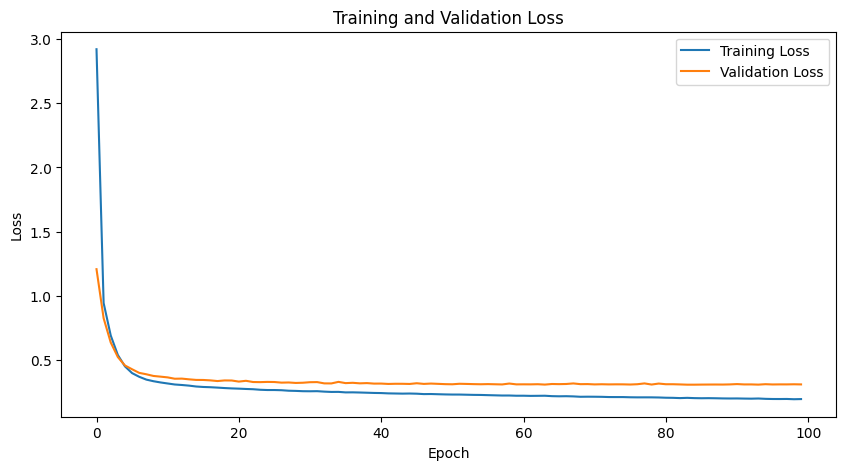

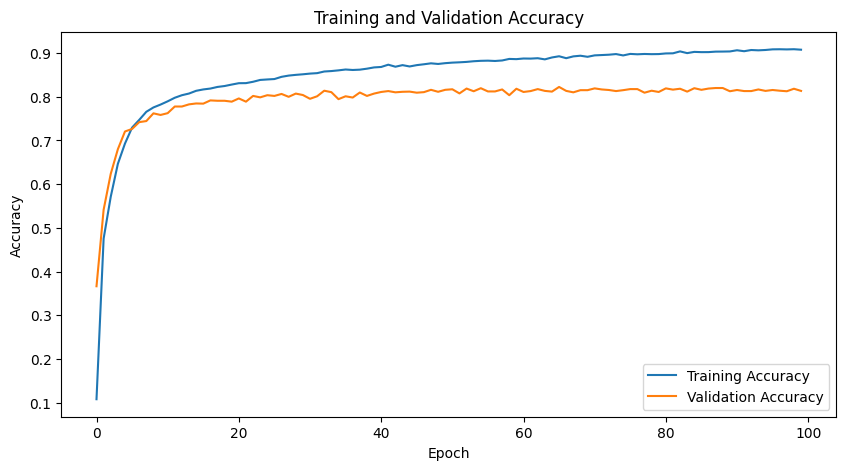

In [87]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# NN Experiment 4: 

## Hyperparameters: 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically nn.L1Loss with reduction method set to mean.
- **optimizer**: SGD optimizer used for model parameter optimization with a learning rate of 0.01 and momentum of 0.9.
- **scheduler**: CyclicLR, with max of 0.01 and base_lr of 0.001. 
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 
- **Hit almost 82% val acc around epoch 50, where train acc hits 93% around epoch 100** (previously best)
- **Hit 83.5% val acc around epoch 70, where train acc hits 93% around epoch 100** (Currently Best)

In [89]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# define cyclic learning rate scheduler
step_size_up = 100  
step_size_down = 200  
base_lr = 0.001 
max_lr = 0.01  
clr_scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
                         step_size_up=step_size_up, step_size_down=step_size_down)

106


In [90]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# training
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 2.9288, Val Loss: 0.6763, Training Accuracy: 11.51%, Validation Accuracy: 53.78%
Epoch 2/100, Loss: 0.4695, Val Loss: 0.3792, Training Accuracy: 64.41%, Validation Accuracy: 70.32%
Epoch 3/100, Loss: 0.3752, Val Loss: 0.3509, Training Accuracy: 71.42%, Validation Accuracy: 74.38%
Epoch 4/100, Loss: 0.3541, Val Loss: 0.3421, Training Accuracy: 74.15%, Validation Accuracy: 73.93%
Epoch 5/100, Loss: 0.3424, Val Loss: 0.3325, Training Accuracy: 75.76%, Validation Accuracy: 76.72%
Epoch 6/100, Loss: 0.3341, Val Loss: 0.3256, Training Accuracy: 76.82%, Validation Accuracy: 77.09%
Epoch 7/100, Loss: 0.3262, Val Loss: 0.3221, Training Accuracy: 77.56%, Validation Accuracy: 77.01%
Epoch 8/100, Loss: 0.3193, Val Loss: 0.3161, Training Accuracy: 78.36%, Validation Accuracy: 78.20%
Epoch 9/100, Loss: 0.3140, Val Loss: 0.3135, Training Accuracy: 79.07%, Validation Accuracy: 79.02%
Epoch 10/100, Loss: 0.3085, Val Loss: 0.3099, Training Accuracy: 79.58%, Validation Accuracy: 79.23%

Epoch 83/100, Loss: 0.1923, Val Loss: 0.2960, Training Accuracy: 91.87%, Validation Accuracy: 82.39%
Epoch 84/100, Loss: 0.1922, Val Loss: 0.2899, Training Accuracy: 91.98%, Validation Accuracy: 82.72%
Epoch 85/100, Loss: 0.1928, Val Loss: 0.2942, Training Accuracy: 91.76%, Validation Accuracy: 82.02%
Epoch 86/100, Loss: 0.1894, Val Loss: 0.2931, Training Accuracy: 92.05%, Validation Accuracy: 81.69%
Epoch 87/100, Loss: 0.1887, Val Loss: 0.2963, Training Accuracy: 92.10%, Validation Accuracy: 82.64%
Epoch 88/100, Loss: 0.1876, Val Loss: 0.2949, Training Accuracy: 92.13%, Validation Accuracy: 82.92%
Epoch 89/100, Loss: 0.1878, Val Loss: 0.3010, Training Accuracy: 92.04%, Validation Accuracy: 81.61%
Epoch 90/100, Loss: 0.1882, Val Loss: 0.2937, Training Accuracy: 92.33%, Validation Accuracy: 83.09%
Epoch 91/100, Loss: 0.1863, Val Loss: 0.2991, Training Accuracy: 92.28%, Validation Accuracy: 82.51%
Epoch 92/100, Loss: 0.1866, Val Loss: 0.2991, Training Accuracy: 92.30%, Validation Accurac

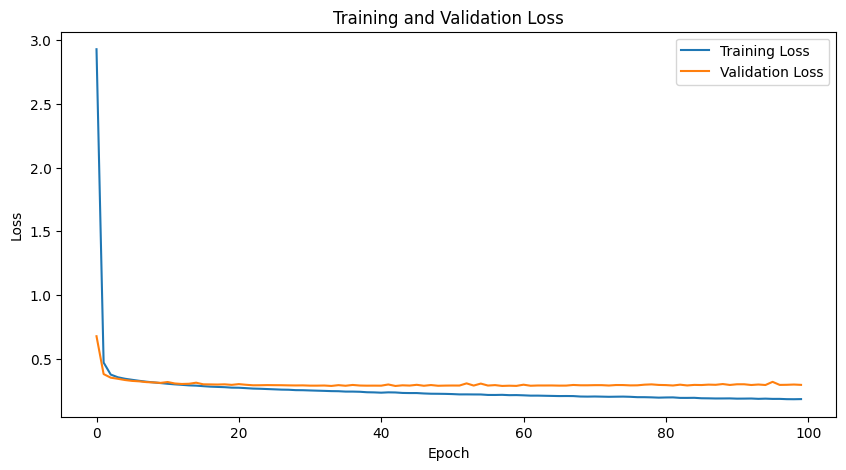

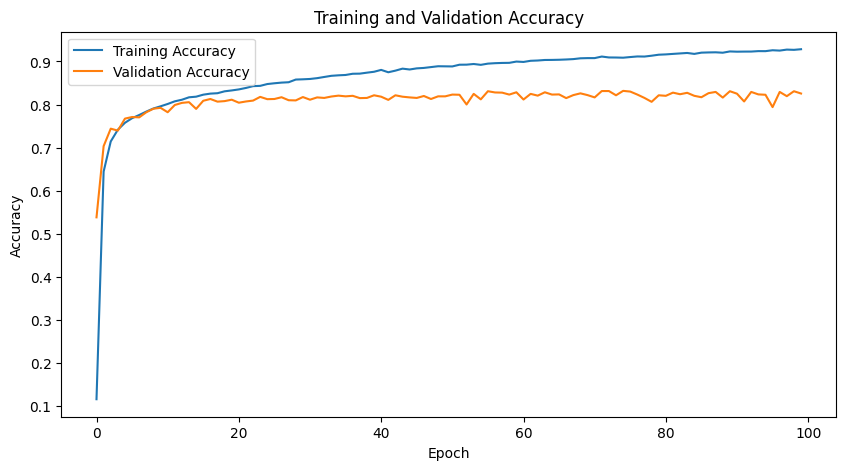

In [91]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# NN Experiment 5: （Different Architecture 5-layer with Dropout)
## Hyperparameters: 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically L1 Loss (Mean Absolute Error) with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: Learning rate scheduler using StepLR method, with a step size of 50 epochs and a gamma value of 0.1.
- **epochs**: Total number of training epochs set to 200.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 

- **Hit 82% val acc around epoch 50, where train acc hits 91% around epoch 54** （without Dropout)
- **Hit 81% val acc around epoch 55, where train acc hits 93% around epoch 100**  (Currently with Dropout)
### We can see a slightly worse val acc due to the regularization technique here. 



In [92]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')  # Using L1Loss for Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 200
threshold = 0.1  # 10% threshold

106


In [93]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 2.2279, Val Loss: 0.9331, Training Accuracy: 23.90%, Validation Accuracy: 50.86%
Epoch 2/100, Loss: 0.7082, Val Loss: 0.5822, Training Accuracy: 56.67%, Validation Accuracy: 64.78%
Epoch 3/100, Loss: 0.4683, Val Loss: 0.4541, Training Accuracy: 67.92%, Validation Accuracy: 69.66%
Epoch 4/100, Loss: 0.3906, Val Loss: 0.4157, Training Accuracy: 72.70%, Validation Accuracy: 72.70%
Epoch 5/100, Loss: 0.3582, Val Loss: 0.3856, Training Accuracy: 75.16%, Validation Accuracy: 75.16%
Epoch 6/100, Loss: 0.3404, Val Loss: 0.3730, Training Accuracy: 76.66%, Validation Accuracy: 76.93%
Epoch 7/100, Loss: 0.3269, Val Loss: 0.3660, Training Accuracy: 78.23%, Validation Accuracy: 76.85%
Epoch 8/100, Loss: 0.3183, Val Loss: 0.3689, Training Accuracy: 79.38%, Validation Accuracy: 77.71%
Epoch 9/100, Loss: 0.3095, Val Loss: 0.3528, Training Accuracy: 80.27%, Validation Accuracy: 78.20%
Epoch 10/100, Loss: 0.3044, Val Loss: 0.3557, Training Accuracy: 80.52%, Validation Accuracy: 79.02%

Epoch 83/100, Loss: 0.1943, Val Loss: 0.3174, Training Accuracy: 91.95%, Validation Accuracy: 80.75%
Epoch 84/100, Loss: 0.1917, Val Loss: 0.3122, Training Accuracy: 92.20%, Validation Accuracy: 81.94%
Epoch 85/100, Loss: 0.1920, Val Loss: 0.3247, Training Accuracy: 92.19%, Validation Accuracy: 80.25%
Epoch 86/100, Loss: 0.1900, Val Loss: 0.3176, Training Accuracy: 92.13%, Validation Accuracy: 81.65%
Epoch 87/100, Loss: 0.1906, Val Loss: 0.3272, Training Accuracy: 92.20%, Validation Accuracy: 80.75%
Epoch 88/100, Loss: 0.1913, Val Loss: 0.3240, Training Accuracy: 92.07%, Validation Accuracy: 81.77%
Epoch 89/100, Loss: 0.1865, Val Loss: 0.3203, Training Accuracy: 92.32%, Validation Accuracy: 81.40%
Epoch 90/100, Loss: 0.1928, Val Loss: 0.3186, Training Accuracy: 91.92%, Validation Accuracy: 81.73%
Epoch 91/100, Loss: 0.1864, Val Loss: 0.3126, Training Accuracy: 92.44%, Validation Accuracy: 82.39%
Epoch 92/100, Loss: 0.1872, Val Loss: 0.3270, Training Accuracy: 92.43%, Validation Accurac

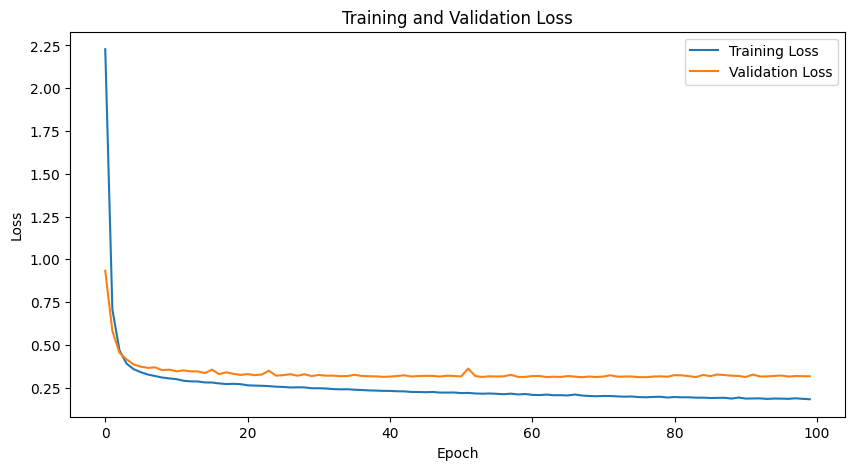

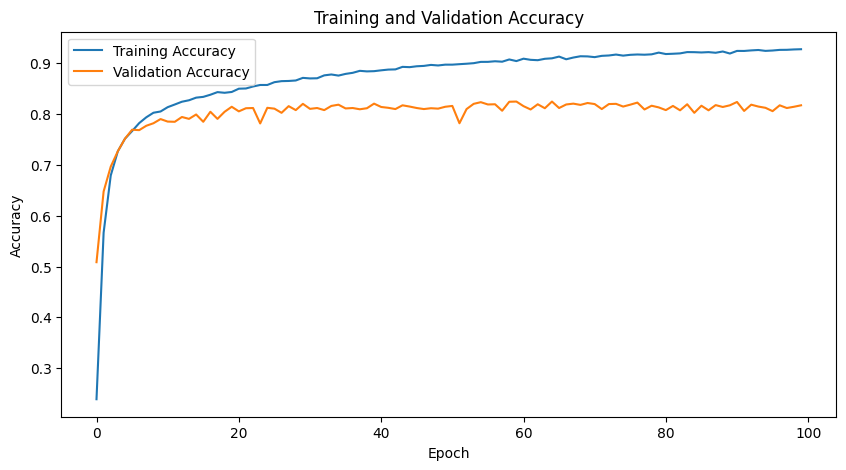

In [94]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# NN Experiment 6: （Different Architecture 5-layer with BatchNormalization)
## Hyperparameters (from the winner of the basci 5-layer architecture): 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically L1 Loss (Mean Absolute Error) with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: Learning rate scheduler using StepLR method, with a step size of 50 epochs and a gamma value of 0.1.
- **epochs**: Total number of training epochs set to 200.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 

- **Hit 82% val acc around epoch 50, where train acc hits 91% around epoch 54** （without Dropout)
- **Hit 83% val acc around epoch 60, where train acc hits 91% around epoch 95**  (Currently with BatchNormalization)
### We can see a slightly worse val and train acc with Batch Normalization. 



In [95]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictorBN(input_size)
criterion = nn.L1Loss(reduction='mean')  # Using L1Loss for Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 200
threshold = 0.1  # 10% threshold

106


In [96]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 3.1875, Val Loss: 0.9051, Training Accuracy: 5.88%, Validation Accuracy: 30.50%
Epoch 2/100, Loss: 0.5081, Val Loss: 0.3694, Training Accuracy: 58.05%, Validation Accuracy: 73.81%
Epoch 3/100, Loss: 0.3941, Val Loss: 0.3715, Training Accuracy: 69.59%, Validation Accuracy: 74.34%
Epoch 4/100, Loss: 0.3644, Val Loss: 0.3468, Training Accuracy: 73.25%, Validation Accuracy: 76.60%
Epoch 5/100, Loss: 0.3472, Val Loss: 0.3289, Training Accuracy: 75.49%, Validation Accuracy: 77.96%
Epoch 6/100, Loss: 0.3392, Val Loss: 0.3164, Training Accuracy: 76.44%, Validation Accuracy: 79.52%
Epoch 7/100, Loss: 0.3300, Val Loss: 0.3165, Training Accuracy: 77.66%, Validation Accuracy: 79.23%
Epoch 8/100, Loss: 0.3173, Val Loss: 0.3130, Training Accuracy: 78.97%, Validation Accuracy: 79.80%
Epoch 9/100, Loss: 0.3204, Val Loss: 0.3170, Training Accuracy: 78.76%, Validation Accuracy: 79.23%
Epoch 10/100, Loss: 0.3099, Val Loss: 0.3074, Training Accuracy: 80.25%, Validation Accuracy: 80.62%


Epoch 83/100, Loss: 0.2249, Val Loss: 0.2795, Training Accuracy: 90.57%, Validation Accuracy: 82.51%
Epoch 84/100, Loss: 0.2217, Val Loss: 0.2824, Training Accuracy: 90.50%, Validation Accuracy: 83.21%
Epoch 85/100, Loss: 0.2237, Val Loss: 0.2799, Training Accuracy: 90.43%, Validation Accuracy: 83.13%
Epoch 86/100, Loss: 0.2221, Val Loss: 0.2775, Training Accuracy: 90.38%, Validation Accuracy: 83.58%
Epoch 87/100, Loss: 0.2218, Val Loss: 0.2786, Training Accuracy: 90.58%, Validation Accuracy: 83.17%
Epoch 88/100, Loss: 0.2196, Val Loss: 0.2878, Training Accuracy: 90.68%, Validation Accuracy: 82.96%
Epoch 89/100, Loss: 0.2211, Val Loss: 0.2808, Training Accuracy: 90.41%, Validation Accuracy: 83.50%
Epoch 90/100, Loss: 0.2199, Val Loss: 0.2805, Training Accuracy: 90.59%, Validation Accuracy: 83.05%
Epoch 91/100, Loss: 0.2183, Val Loss: 0.2803, Training Accuracy: 90.84%, Validation Accuracy: 83.54%
Epoch 92/100, Loss: 0.2230, Val Loss: 0.2842, Training Accuracy: 90.37%, Validation Accurac

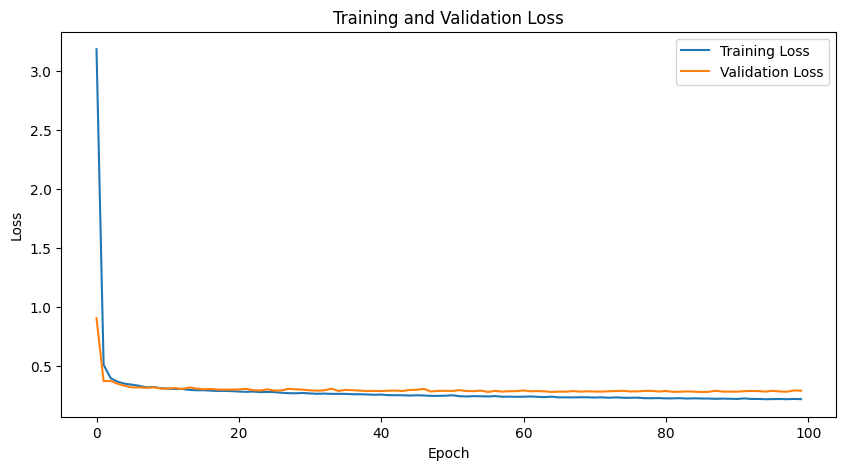

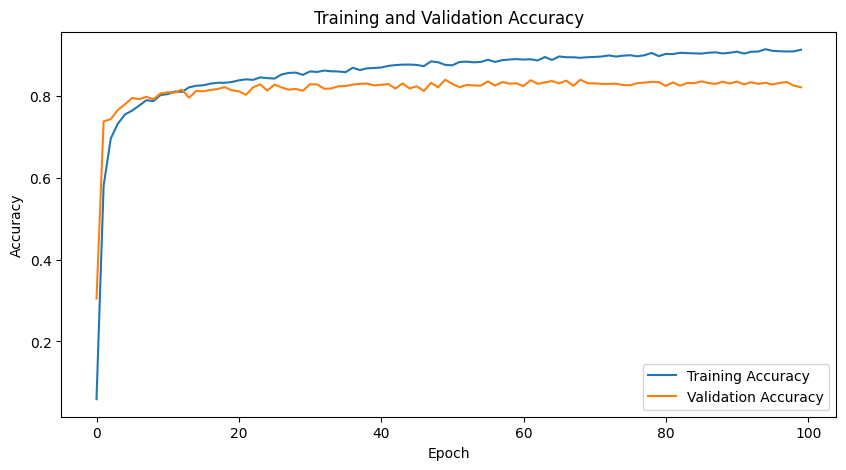

In [97]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# NN Experiment 7: （Different Architecture 9-layer)
## Hyperparameters (from the winner of the basci 5-layer architecture): 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor9Layers` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically L1 Loss (Mean Absolute Error) with reduction method set to mean.
- **optimizer**: Adam optimizer used for model parameter optimization with a learning rate of 0.0002.
- **scheduler**: Learning rate scheduler using StepLR method, with a step size of 50 epochs and a gamma value of 0.1.
- **epochs**: Total number of training epochs set to 200.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results: 

- **Hit 83.5% val acc around epoch 70, where train acc hits 93% around epoch 100** (The best so far)
- **Hit almost 82% val acc around epoch 98, where train acc hits alsmot 98% around epoch 100**  (Currently with 9 layers)
### Although with more layers, we can see a much better train accuracy, but we do not see a better val accuracy. This may indicate that overfitting has occurred with this more complex architecture. We also see some unusual val acc fluctuations around epoch 16. 


In [98]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor9Layer(input_size)
criterion = nn.L1Loss(reduction='mean')  # Using L1Loss for Mean Absolute Error
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 200
threshold = 0.1  # 10% threshold

106


In [99]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0  # Separate variables for training accuracy calculation
    train_total_predictions = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Check for NaN values in inputs
        if np.isnan(inputs).any():
            print("NaN values detected in inputs!")
            # Handle NaN values appropriately
            
        # Check for NaN values in labels
        if np.isnan(labels).any():
            print("NaN values detected in labels!")
            # Handle NaN values appropriately
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate absolute percentage error for accuracy-like metric
        abs_percentage_error = torch.abs(outputs - labels) / labels
        
        # Count correct predictions within the threshold
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions  # Using separate variables
    
    # Append training loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate absolute percentage error for accuracy-like metric
            abs_percentage_error = torch.abs(outputs - labels) / labels
            
            # Count correct predictions within the threshold
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions
    
    # Append validation loss and accuracy to lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')


Epoch 1/100, Loss: 1.5027, Val Loss: 0.5710, Training Accuracy: 37.72%, Validation Accuracy: 60.51%
Epoch 2/100, Loss: 0.4489, Val Loss: 0.4080, Training Accuracy: 67.00%, Validation Accuracy: 71.35%
Epoch 3/100, Loss: 0.3748, Val Loss: 0.3707, Training Accuracy: 72.99%, Validation Accuracy: 73.32%
Epoch 4/100, Loss: 0.3534, Val Loss: 0.3581, Training Accuracy: 75.25%, Validation Accuracy: 75.66%
Epoch 5/100, Loss: 0.3340, Val Loss: 0.3477, Training Accuracy: 77.06%, Validation Accuracy: 76.93%
Epoch 6/100, Loss: 0.3188, Val Loss: 0.3552, Training Accuracy: 78.76%, Validation Accuracy: 76.64%
Epoch 7/100, Loss: 0.3114, Val Loss: 0.3384, Training Accuracy: 79.98%, Validation Accuracy: 78.04%
Epoch 8/100, Loss: 0.3121, Val Loss: 0.3515, Training Accuracy: 79.73%, Validation Accuracy: 77.05%
Epoch 9/100, Loss: 0.3075, Val Loss: 0.3179, Training Accuracy: 80.76%, Validation Accuracy: 80.13%
Epoch 10/100, Loss: 0.2953, Val Loss: 0.3470, Training Accuracy: 81.94%, Validation Accuracy: 77.79%

Epoch 83/100, Loss: 0.1534, Val Loss: 0.3050, Training Accuracy: 96.19%, Validation Accuracy: 81.08%
Epoch 84/100, Loss: 0.1530, Val Loss: 0.3061, Training Accuracy: 95.90%, Validation Accuracy: 81.28%
Epoch 85/100, Loss: 0.1493, Val Loss: 0.3006, Training Accuracy: 96.27%, Validation Accuracy: 82.39%
Epoch 86/100, Loss: 0.1502, Val Loss: 0.2986, Training Accuracy: 96.03%, Validation Accuracy: 81.94%
Epoch 87/100, Loss: 0.1531, Val Loss: 0.3049, Training Accuracy: 96.18%, Validation Accuracy: 81.08%
Epoch 88/100, Loss: 0.1487, Val Loss: 0.3211, Training Accuracy: 96.26%, Validation Accuracy: 78.94%
Epoch 89/100, Loss: 0.1462, Val Loss: 0.3013, Training Accuracy: 96.36%, Validation Accuracy: 82.39%
Epoch 90/100, Loss: 0.1527, Val Loss: 0.3455, Training Accuracy: 96.17%, Validation Accuracy: 77.83%
Epoch 91/100, Loss: 0.1525, Val Loss: 0.2982, Training Accuracy: 96.24%, Validation Accuracy: 82.27%
Epoch 92/100, Loss: 0.1445, Val Loss: 0.3003, Training Accuracy: 96.43%, Validation Accurac

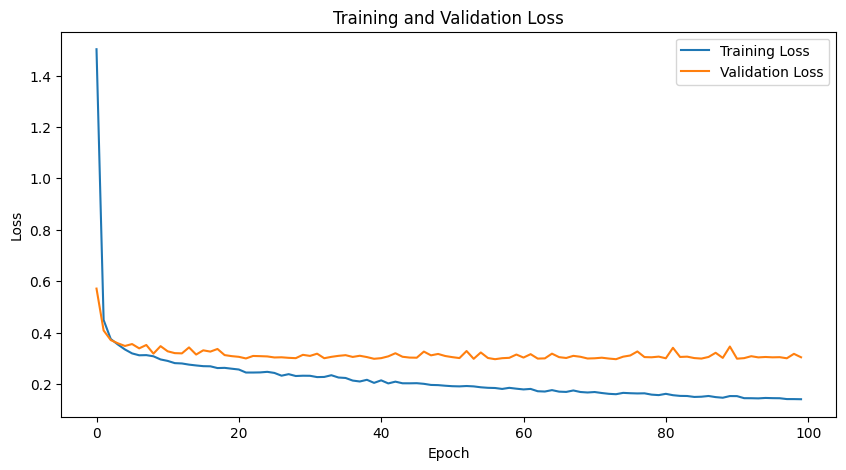

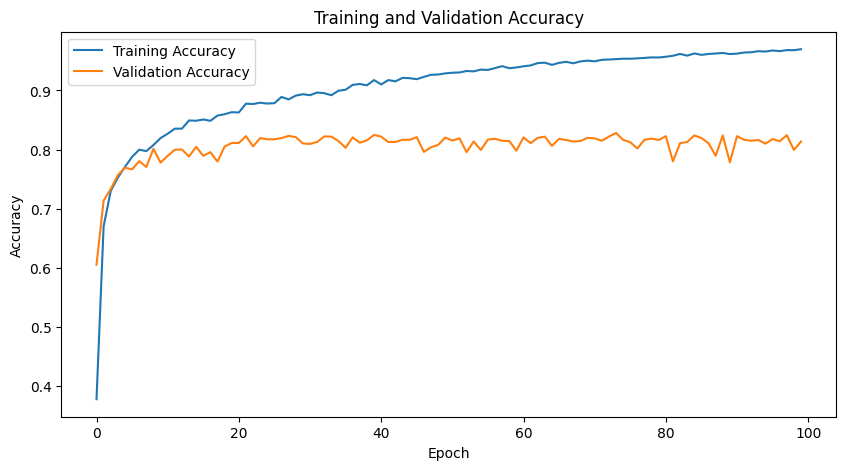

In [100]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## We use the best loss function, optimizer and lr scheduler combination to model the test set

# NN Experiment 4: 

## Hyperparameters: 
- **input_size**: Dimensionality of the input features in the training data. (106)
- **model**: Instance of the `AirbnbPricePredictor` model with input size `input_size`.
- **criterion**: Loss function used for optimization, specifically nn.L1Loss with reduction method set to mean.
- **optimizer**: SGD optimizer used for model parameter optimization with a learning rate of 0.01 and momentum of 0.9.
- **scheduler**: CyclicLR, with max of 0.01 and base_lr of 0.001. 
- **epochs**: Total number of training epochs set to 100.
- **threshold**: Convergence threshold set to 0.1, indicating a 10% change in loss between epochs for early stopping or other convergence criteria.

### Results with test set: 
- **Hit 81.5 test acc around epoch 60, 83.5% val acc around epoch 70, where train acc hits 93% around epoch 100** (Currently Best)

In [135]:
# the same structure as before, just add predict function
class AirbnbPricePredictor(nn.Module):
    def __init__(self, input_size):
        super(AirbnbPricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  
        self.fc2 = nn.Linear(256, 128)       
        self.fc3 = nn.Linear(128, 64)          
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    def predict(self, X):
        self.eval() 
        with torch.no_grad(): 
            if isinstance(X, np.ndarray):
                X = torch.from_numpy(X).float()
            output = self.forward(X)
            return output.numpy() 

In [136]:
input_size = X_train_tensor.shape[1]
print(input_size)
model = AirbnbPricePredictor(input_size)
criterion = nn.L1Loss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# define cyclic learning rate scheduler
step_size_up = 100  
step_size_down = 200  
base_lr = 0.001 
max_lr = 0.01  
clr_scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
                         step_size_up=step_size_up, step_size_down=step_size_down)

106


In [127]:
# Initialize lists to collect metrics
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct_predictions = 0
    train_total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Input and label NaN checks would be similar to previous snippet
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        abs_percentage_error = torch.abs(outputs - labels) / labels
        train_correct_predictions += torch.sum(abs_percentage_error <= threshold)
        train_total_predictions += len(labels)

    epoch_loss = running_loss / len(train_loader.dataset)
    training_accuracy = train_correct_predictions / train_total_predictions
    
    train_losses.append(epoch_loss)
    train_accuracies.append(training_accuracy)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            abs_percentage_error = torch.abs(outputs - labels) / labels
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    validation_accuracy = correct_predictions / total_predictions

    val_losses.append(epoch_val_loss)
    val_accuracies.append(validation_accuracy)

    # Test set evaluation
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            abs_percentage_error = torch.abs(outputs - labels) / labels
            correct_predictions += torch.sum(abs_percentage_error <= threshold)
            total_predictions += len(labels)

    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = correct_predictions / total_predictions

    test_losses.append(epoch_test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}, Test Accuracy: {test_accuracy:.2%}')


Epoch 1/100, Loss: 2.4913, Val Loss: 0.5613, Test Loss: 0.5673, Training Accuracy: 18.83%, Validation Accuracy: 58.91%, Test Accuracy: 56.84%
Epoch 2/100, Loss: 0.4350, Val Loss: 0.3745, Test Loss: 0.3882, Training Accuracy: 66.34%, Validation Accuracy: 70.85%, Test Accuracy: 71.19%
Epoch 3/100, Loss: 0.3714, Val Loss: 0.3506, Test Loss: 0.3689, Training Accuracy: 71.87%, Validation Accuracy: 73.65%, Test Accuracy: 73.41%
Epoch 4/100, Loss: 0.3526, Val Loss: 0.3405, Test Loss: 0.3602, Training Accuracy: 74.03%, Validation Accuracy: 75.16%, Test Accuracy: 74.63%
Epoch 5/100, Loss: 0.3412, Val Loss: 0.3347, Test Loss: 0.3522, Training Accuracy: 75.76%, Validation Accuracy: 75.66%, Test Accuracy: 75.24%
Epoch 6/100, Loss: 0.3328, Val Loss: 0.3267, Test Loss: 0.3418, Training Accuracy: 76.91%, Validation Accuracy: 77.46%, Test Accuracy: 77.62%
Epoch 7/100, Loss: 0.3253, Val Loss: 0.3223, Test Loss: 0.3380, Training Accuracy: 77.94%, Validation Accuracy: 77.71%, Test Accuracy: 77.40%
Epoch 

Epoch 59/100, Loss: 0.2152, Val Loss: 0.2822, Test Loss: 0.3002, Training Accuracy: 89.72%, Validation Accuracy: 82.92%, Test Accuracy: 81.61%
Epoch 60/100, Loss: 0.2119, Val Loss: 0.2804, Test Loss: 0.2971, Training Accuracy: 89.88%, Validation Accuracy: 82.68%, Test Accuracy: 81.50%
Epoch 61/100, Loss: 0.2136, Val Loss: 0.2825, Test Loss: 0.2960, Training Accuracy: 89.86%, Validation Accuracy: 82.72%, Test Accuracy: 81.39%
Epoch 62/100, Loss: 0.2130, Val Loss: 0.2830, Test Loss: 0.2958, Training Accuracy: 89.94%, Validation Accuracy: 82.88%, Test Accuracy: 80.78%
Epoch 63/100, Loss: 0.2103, Val Loss: 0.2847, Test Loss: 0.2992, Training Accuracy: 90.08%, Validation Accuracy: 82.76%, Test Accuracy: 80.94%
Epoch 64/100, Loss: 0.2082, Val Loss: 0.2814, Test Loss: 0.2985, Training Accuracy: 90.28%, Validation Accuracy: 82.76%, Test Accuracy: 81.66%
Epoch 65/100, Loss: 0.2070, Val Loss: 0.2952, Test Loss: 0.3067, Training Accuracy: 90.46%, Validation Accuracy: 81.94%, Test Accuracy: 80.28%

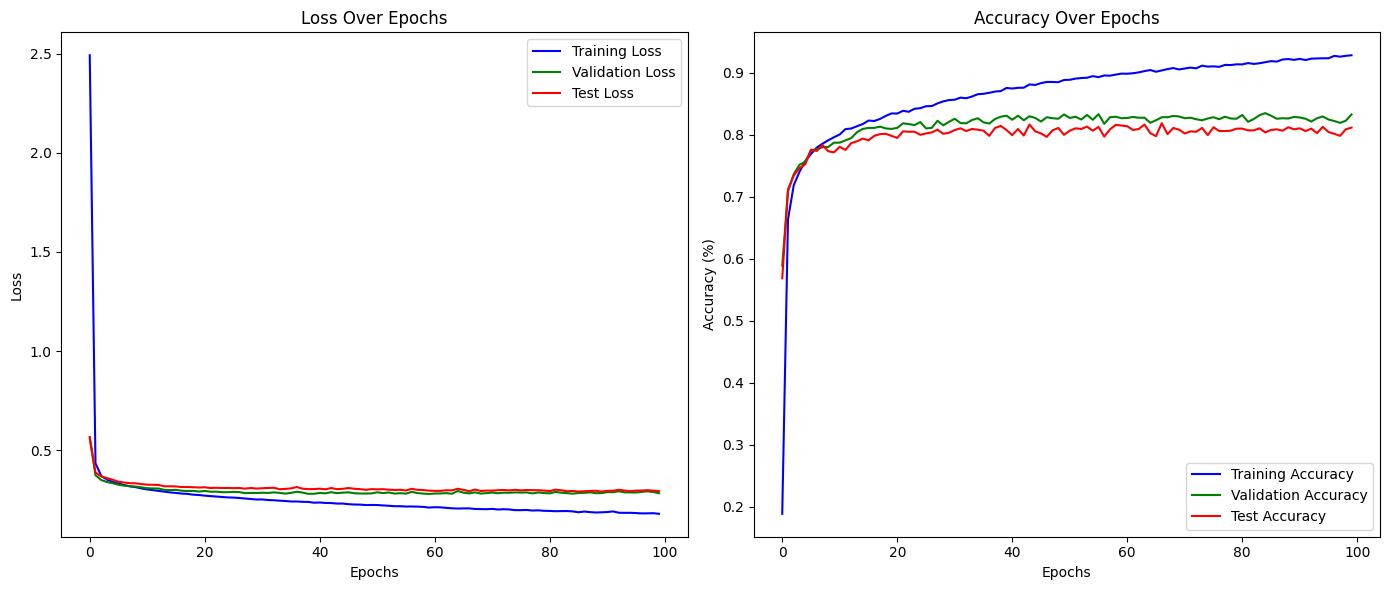

In [129]:
plt.figure(figsize=(14, 6))

# Create subplot for loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.plot(test_losses, label='Test Loss', color='red')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Create subplot for accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.plot(test_accuracies, label='Test Accuracy', color='red')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show the plots
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()


In [137]:
from sklearn.metrics import mean_absolute_percentage_error

def scores(X_train, X_test, y_train, y_test, model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # 计算R2
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    # 计算训练集上的MSE和RMSE
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    # 计算测试集上的MSE和RMSE
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    # 计算训练集和测试集上的MAPE
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"Train R2 score: {train_score}, Test R2 score {test_score}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train MAPE: {train_mape}, Test MAPE: {test_mape}")

# 用你的模型实例替换'model'
# scores(X_train, X_test, y_train, y_test, model)


In [138]:
scores(X_train, X_test, y_train, y_test, model)

Train R2 score: -39.96383897853607, Test R2 score -37.813799475778715
Train MSE: 25.64567077863455, Test MSE: 25.375530184328255
Train RMSE: 5.064155485234883, Test RMSE: 5.037413044840402
Train MAPE: 1.0284420758814283, Test MAPE: 1.028554229214467
